# The Many Variables And The Spurious Waffles

It turns out that places with lots of Waffle House restaurants have a high divorce rate; those with none have a lower one. Probably a spurious correlation. (Almost surely because Waffle House was founded and mostly remains in the southern US, where the divorce rate is also high).

- Multiple regression - using more than one predictor variable to simultaneously model an outcome

Reasons for multiple regression models include:
1. Statistical controls for confounds. A _confound_ is something which misleads us about a causal influence (more precise definition later). The spurious waffles and divorce correlation is one kind of confound, where southernness makes a variable with no real importance (Waffle House density) appear important. There are other types.
2. Multiple and complex causation. A phenomenon may arise from multiple simultaneous causes, and causes can cascade in complex ways. And since one cause can hide another, they must be measured simultaneously.
3. Interactions. The importance of one variable may depend upon another. For example, plants benefit from both light and water. However, in the absence of either, the other is no benefit at all. Such internactions occur very often. Effective interference about one variable will often depend upon consideration of others.

- _main effects_: additive combinations of variables
- Also deal with *categorical variables*

## Spurious Correlation


In [1]:
library(rethinking)
library(ggplot2)
library(dagitty)

Loading required package: rstan

Loading required package: StanHeaders

Warning message:
“package ‘StanHeaders’ was built under R version 4.2.0”
Loading required package: ggplot2

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/eric/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0

Loading required package: parallel

rethinking (Version 2.31)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
data(WaffleDivorce)
d <- WaffleDivorce
head(d)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00


In [3]:
# standardizing the data
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)
d$A <- standardize(d$MedianAgeMarriage)

We can model the divorce rate against the marriage rate using the following linear model:

$$
\begin{align*}
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A &\sim\text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Where $D_i$ is the standardized (zero mean, standard deviation 1) divorce rate for state $i$ and $A_i$ is state $i$'s standardized median age at marriage. 

In [4]:
m5.1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d
)

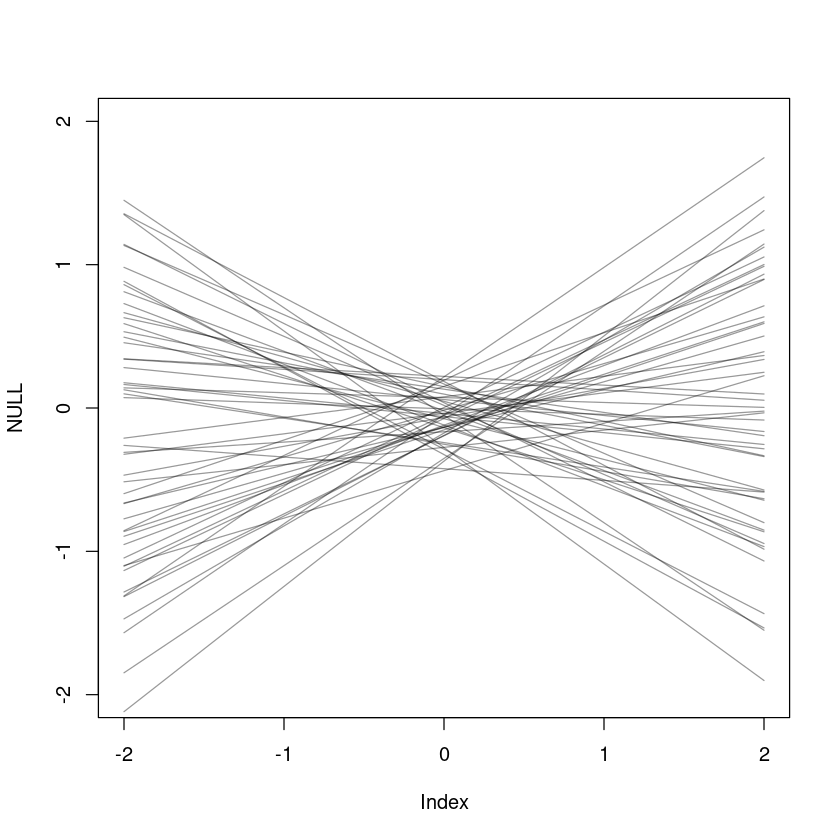

In [5]:
set.seed(10)
prior <- extract.prior(m5.1)
mu <- link(m5.1, post=prior, data=list(A=c(-2,2)))
plot(NULL, xlim=c(-2,2), ylim=c(-2,2))
for (i in 1:50) {
    lines( c(-2,2), mu[i,], col=col.alpha("black", 0.4))
}

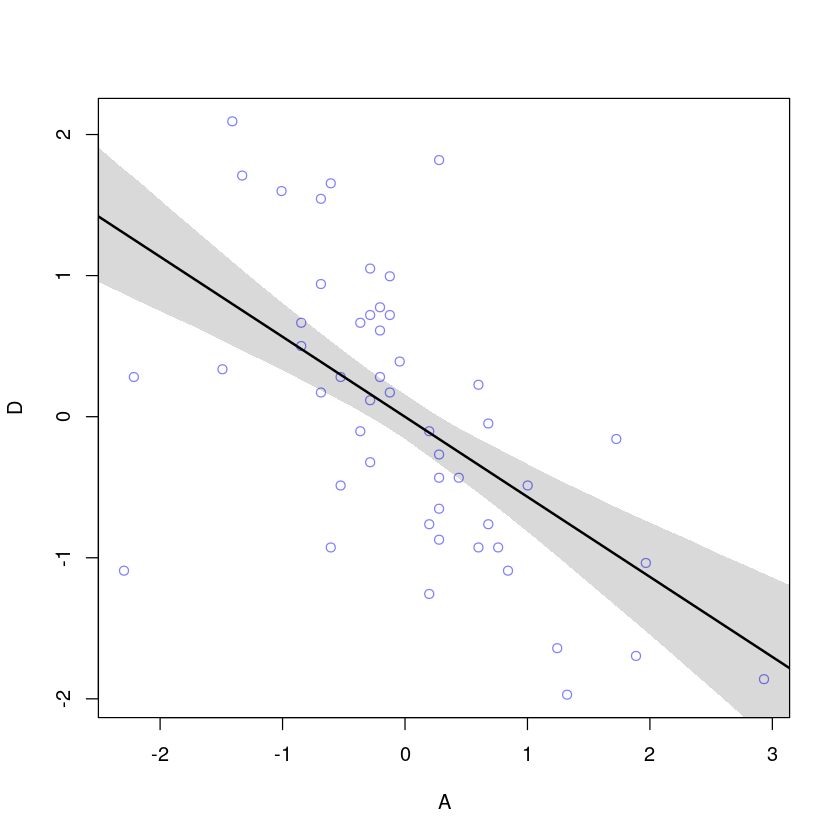

In [6]:
# Now for the posterior predictions.
# Procedure is the same as in the examples from the previous chapter - link, then summarize with mean and PI, then plot

# compute the percentile interval of the mean
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.1, data=list(A=A_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

# plot it all
plot(D~A, data=d, col=rangi2)
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

In [7]:
precis(m5.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.645780e-08,0.09737877,-0.1556301,0.1556301
bA,-5.684034e-01,0.10999980,-0.7442044,-0.3926025
sigma,7.883257e-01,0.07801134,0.6636485,0.9130029


In [8]:
m5.2 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d
)

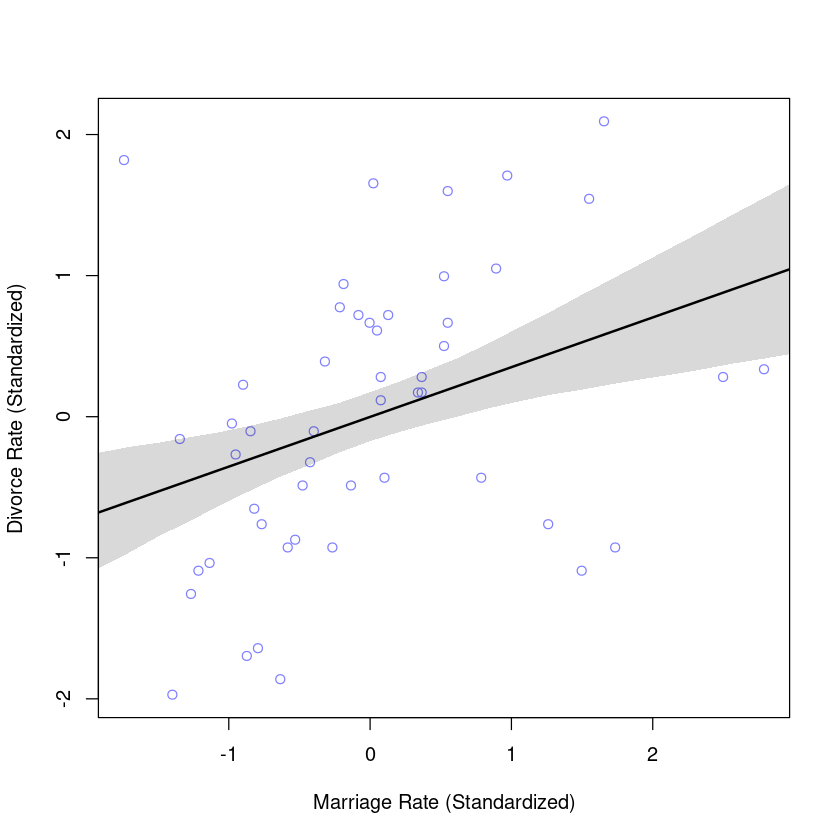

In [9]:
M_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.2, data=list(M=M_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

# plot it all
plot(D~M, data=d, col=rangi2, xlab="Marriage Rate (Standardized)", ylab="Divorce Rate (Standardized)")
lines(M_seq, mu.mean, lwd=2)
shade(mu.PI, M_seq)

### Think Before you Regress

There are three variables at play here:
1. $D$, the divorce rate;
1. $M$, the marriage rate;
1. $A$, the median age at marriage

The regressions that we've done so far assume that only one of those has a causative effect - we only ran the model conditional on one of the other variables!

To understand this, let's take a look at a DAG: directed acyclic graph.

Let's start with a simple DAG:

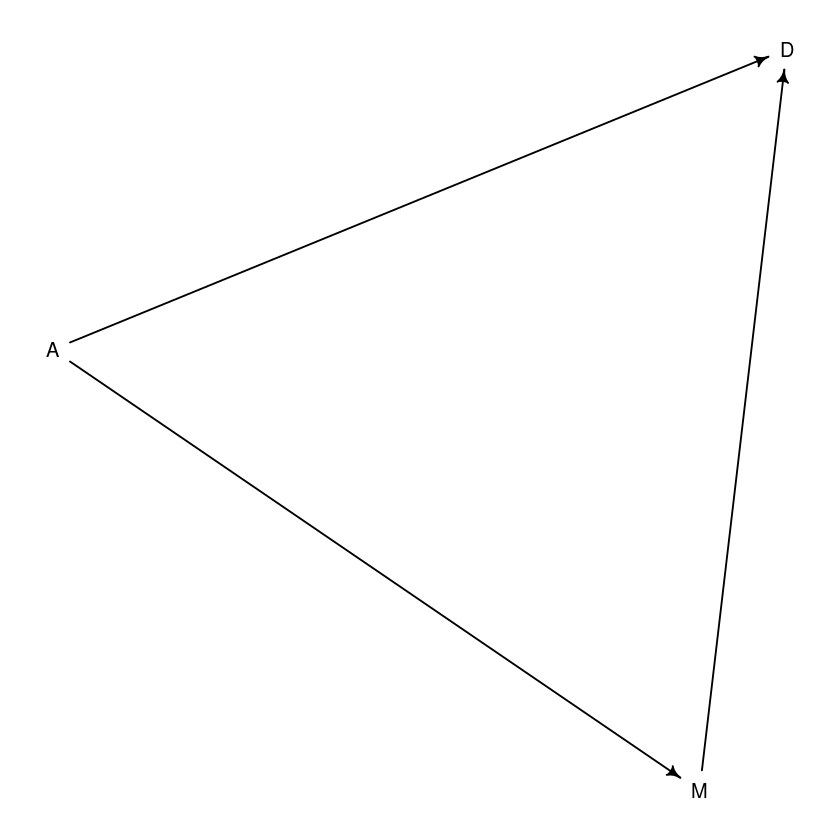

In [10]:
dag5.1 <- dagitty("dag{ A -> D; A -> M; M -> D }")
drawdag(dag5.1)

This means that $A$ directly influences $D$, $A$ directly influences $M$, and $M$ directly influences $D$. This diagram allows us to see a lot about how the variables affect each other! For instance, we can see that $A$ influences $D$ in two ways:
1. It affects it directly
2. It affects $M$, which then in turn affects $D$.

To infer the strength of the different arrows, we need another model. Model 5.1 only tells us that the *total* influence of $A$ on $D$ is negative. However, this effect comes from All of the paths from $A$ to $D$. Here there are two:
1. $A \to D$ 
1. $A \to M \to D$

In fact, it is possible for a variable to have no direct effects on a target variable, but to still have an effect on it. This is known as **mediation**.

However, in our case we can be pretty sure that the indirect path is doing little. From model 5.2, we know that the marriage rate is positively associated with the divorce rate. However, that isn't enough to tell us that $M \to D$ is positive. It is possible that all of the effect between $M$ and $D$ arises from the indirect effects of $A$:

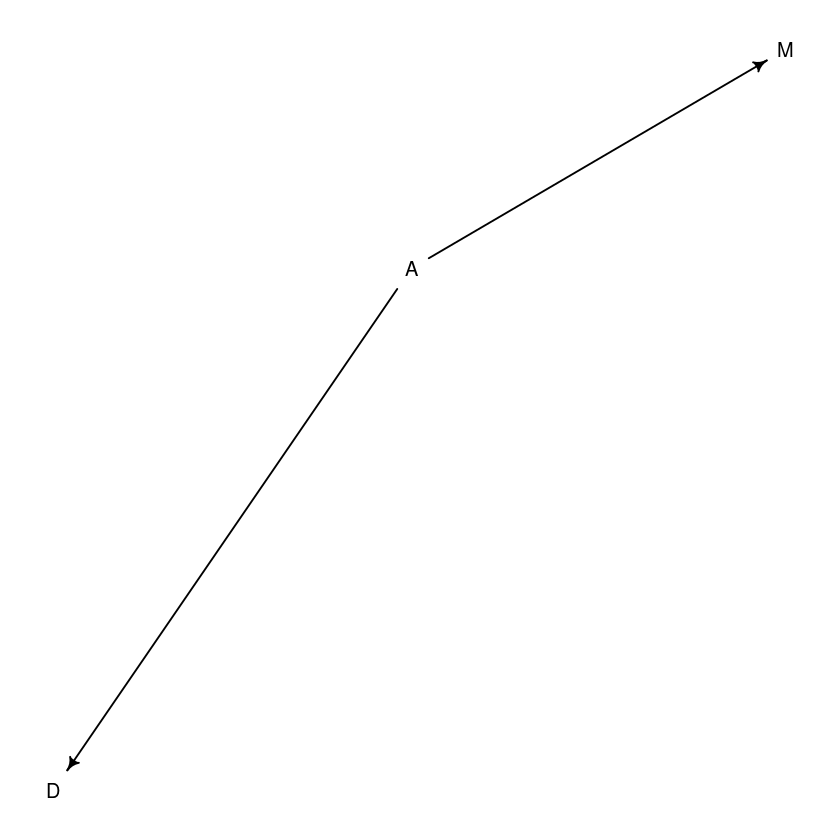

In [11]:
alternateDag5.1 <- dagitty("dag{A -> M; A -> D}")
drawdag(alternateDag5.1)

This is also consistent with the posteriors that we found for models 5.1 and 5.2. Both $D$ and $M$ "listen" to $A$, so when we found the associated from $D$ to $M$, we might just have been picking up on this information. So which of these models is correct?

### Testable Implications

How can we use the data to consider different, but plausible, models? We need to consider the *testable implications* of each model.

Any DAG has some variables that are independent of others, under certain conditions. These are the model's testable implications (**conditional independencies**). Come in two forms:
1. Statements of which variables should be associated with each other (or not) in the data
1. Statements of which variables become dis-associated when we *condition* on another variable

Conditioning on variable $Z$ means leanring its value, and then asking if $X$ adds any additional information about $Y$. If learning about $X$ doesn't tell you anything about $Y$, then we say that $Y$ is independent of $X$, conditional on $Z$. Mathematically:
$Y \perp X | Z$

For the first DAG (the one with all of the arrows), every variable is associated with every other variable - there is a path between every pair. Before we condition on anything, all of the variables are dependent:
$$
\begin{align*}
D \not\perp A && D \not\perp M && A \not\perp M
\end{align*}
$$

That means that if we look at the data and any of the variables are *not* associated, something is wrong with the DAG! We can check that all of our variables are associated by using `cor` to measure that correlation. This doesn't always work (not all associations are correlations), but it does for us

In [12]:
cor(d$D, d$A)

[1] -0.5972392

In [13]:
cor(d$D, d$M)

[1] 0.3737314

In [14]:
cor(d$A, d$M)

[1] -0.721096

So now let's look at the second one. In this case all three variables are associated with each other. However, all of the information on how $M$ influences $D$ is contained in $A$. Thus, if we condition on $A$, there should be no association! Thus, we have a testable prediction:
$$
D \perp M | A
$$

We can use dagitty to get these as well:

In [15]:
DMA_dag2 <- dagitty("dag{D <- A -> M}")
impliedConditionalIndependencies(DMA_dag2)

D _||_ M | A

If we tried the same thing for the first one, there would be no implied conditional independencies.

The only difference in implication between the first and second model is the implied independency of $D$ to $M$ conditional on $A$, so that's what we need to test. To do so, we need a model that conditions on $A$. That is exactly what multiple regression helps us with! It addresses the question:

> Is there any additional value in knowing a variable once I already know all of the other predictor variables?

E.g. once you've fit a multiple regression to predict divorce using both marriage rate and age at marriage, the model addresses the questions:
1. After knowing the marriage rate, what additional value is there in also knowing the age at marriage?
1. After knowing the age at marriage, what additional value is there in also knowing the marriage rate?

The parameter estimates corresponding to each predictor are the (opaque) answers to these questions. The questions are descriptive, and the answers are also descriptive. It is only the derivation of the testable implications above that give these *descriptive* results a *causal* meaning. However, the meaning is still dependent on believing the DAG.

This method is often called *statistical control* (as in, "the analysis controlled for the variable $X$"). However, this is very different from an *experimental control*. *Controlling* statistically still means believing in the model. This is another "large world" vs. "small world" distinction.

### Multiple Regression Notation

Multiple regression looks basically the same as single-variable regression, just with... more variables and more coefficients!

Adding the marriage age to our model:

$$
\begin{align*}
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A &\sim\text{Normal}(0, 0.5) \\
\beta_M &\sim\text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

---
Note that sometimes we'll see the same model written in a more compact format:

$$
\mu_i = \alpha + \sum_{j=1}^n \beta_j x_{ij}
$$

We can even make this more compact:
$$
m = Xb
$$
where $m$ is a vector of preicted means for each row in the data, $b$ is a column matrix of parameters, and $X$ is a matrix. This matrix is called the *design matrix*. 
- As many rows as the data
- As many columns as there are predictors + 1 (also adds in a column of 1s to deal with the constant)

In R notation, this is `X %*% b`

---

In [16]:
m5.3 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m5.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,6.145791e-06,0.09707503,-0.1551385,0.1551508
bM,-6.539899e-02,0.15077111,-0.3063603,0.1755624
bA,-6.135264e-01,0.15098166,-0.8548242,-0.3722285
sigma,7.851074e-01,0.07784077,0.6607028,0.9095120


Note: $bM$ now has a mean close to zero. The posterior mean for $bA$ is basically unchanged.

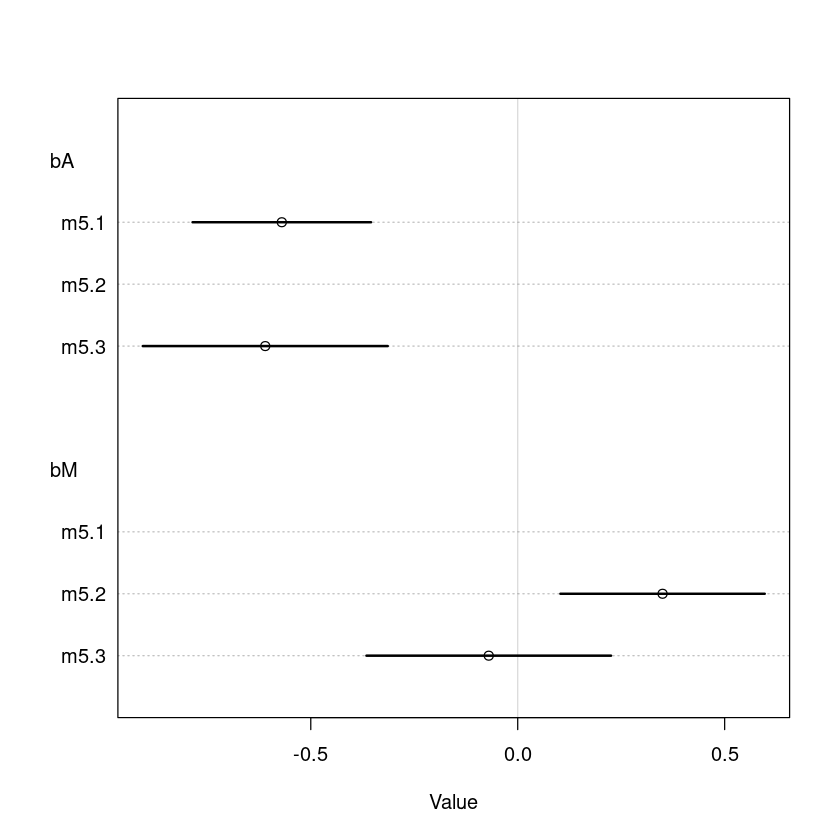

In [17]:
# plot of posterior parameter values for all 3 models
plot(
    coeftab(m5.3, m5.2, m5.1), par=c('bA', 'bM')
)

Notice that $bA$ doesn't really move, it just gets less certain. Note also that $bM$ is only associated with divorce when the age at marriage is *not* part of the model (doesn't include 0). We can interpret this as
> Once the know the median age at marriage for a state, there is little or no additional predictive power in also knowing the rate of marriage in that state.

(Recall: $M$ is marriage rage, $A$ is the median age at marriage)

Or: $D \perp M|A$. This tests that implication of the second DAG from earlier. First DAG did not imply this result -> it is out.

This doesn't mean that there's no value to knowing the marriage rate. For instance, if you didn't have the median age at marriage ($A$), then you can still use the marriage rate to help you. It's *predictive*, but not *causal*.

### Plotting Multivariate Posteriors

Lots of moving parts here

Difficult to visualize, since there are lots of dimensions

Three examples of interpretive plots for multivariable regression:
1. *Predictor residual plots*: Show the outcome against *residual* predictor values. Useful for understanding he statistical model, but not much else
1. *Posterior prediction plots*: These show model-based preidctions against raw data, or otherwise display the error in prediction. They are tools for checking fir and assessing predictions; they are not causal tools.
1. *Counterfactual plots*: These show the implied predictions for imaginary experiments. These plots allow you to explore the causal implications of manipulating one or more variables.

#### Predictor Residual Plots

A *predictor residual* is the average prediction error when we use all of the other predictor variables to model a predictor of interest. One benefit is that, once plotted against the outcome, we have a bivariate regression already conditioned on all of the other predictor variables. It leaves the variabtion that is *not* expected by the model of the mean, $\mu$, as a function of the other predictors.

In our model, we have two predictors: marriage rate M and median age at marriage A. To compute the predictor residuals, we just use the other predictor to model it. For marriage rate here is that model:

$$
\begin{align*}
M_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta A_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

When a residual is negative, we have a *lower than expected* marriage rate for their median age at marriage; when it's positive, it's *higher than expected*.

In [18]:
# code to approximate the posterior
m5.4 <- quap(
    alist(
        M ~ dnorm(mu, sigma),
        mu <- a + bAM * A,
        a ~ dnorm(0, 0.2),
        bAM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

# now compute the *residuals* by subtracting the observed marriage rate in each state:
mu <- link(m5.4)
mu_mean <- apply(mu, 2, mean)
mu_resid <- d$M - mu_mean
mu_resid_pi <- apply(mu, 2, PI)

In [19]:
plot_df <- data.frame(
    M=d$M, # marriage rate
    A=d$A, # age at marriage
    D=d$D, # Divorce rate
    mu_resid=mu_resid
)

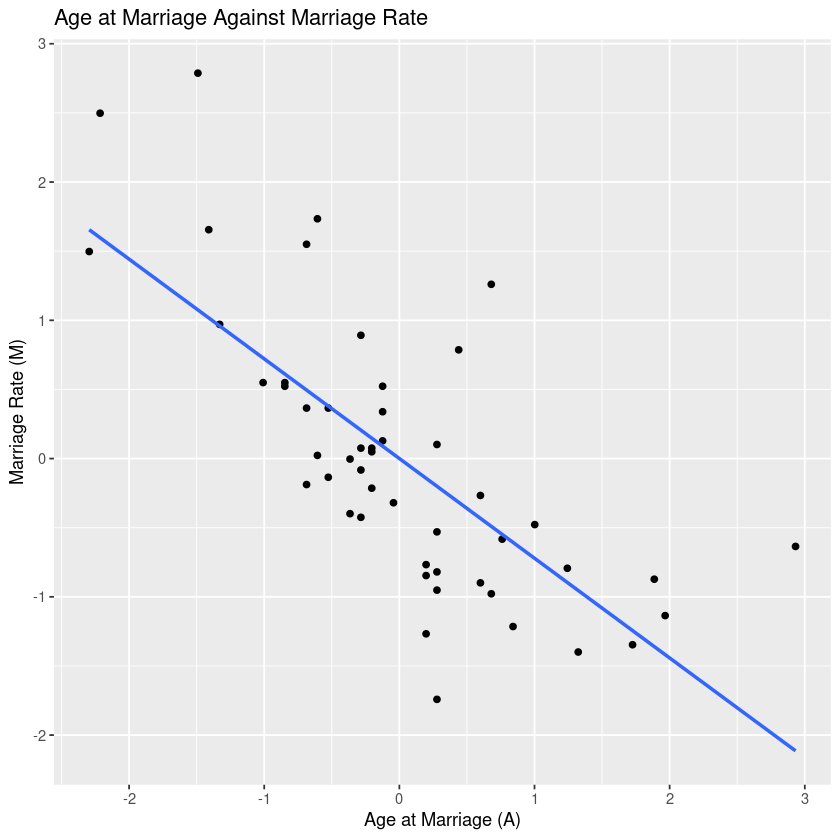

In [20]:
ggplot() +
    geom_point(data=plot_df,aes(A, M)) + 
    geom_smooth(data=plot_df, aes(A, M), method='lm', se=FALSE, formula=y ~ x) + 
    xlab("Age at Marriage (A)") +
    ylab('Marriage Rate (M)') + 
    ggtitle('Age at Marriage Against Marriage Rate')

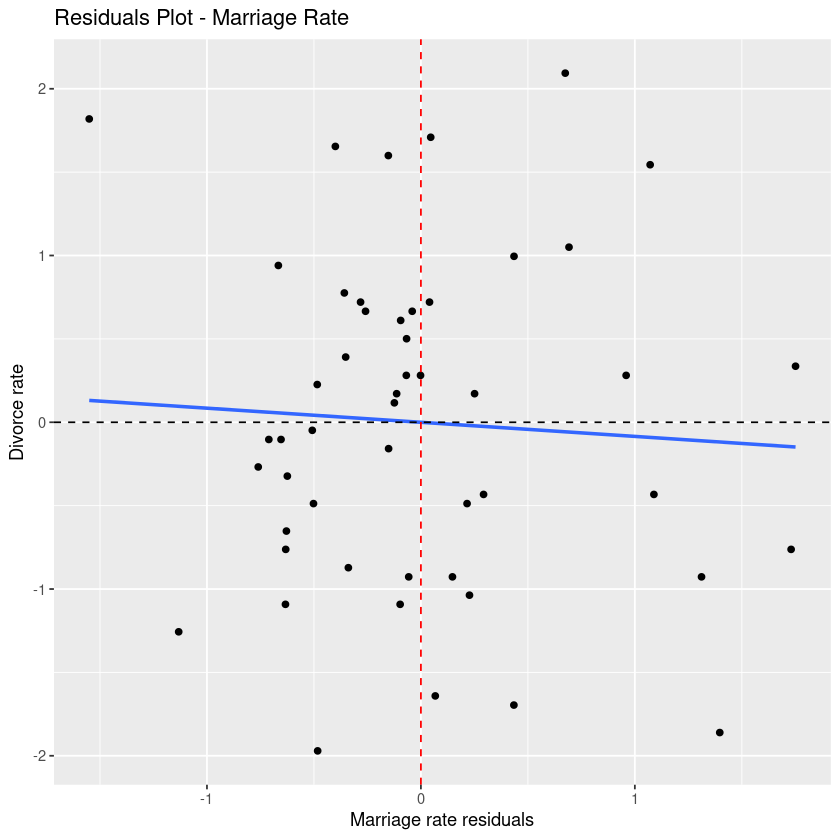

In [21]:
ggplot(plot_df, aes(mu_resid, D)) + 
    geom_point() + 
    geom_smooth(method='lm', se=FALSE, formula=y ~ x) + 
    geom_hline(yintercept=0, linetype=2) +
    geom_vline(xintercept=0, linetype=2, colour='red') +
    xlab("Marriage rate residuals") +
    ylab('Divorce rate') + 
    ggtitle('Residuals Plot - Marriage Rate')

You can think of this as displaying the linear relationship between divorce and marriage rate, *after conditioning on median age of marriage*. The effect seems pretty close to zero. The states on either side of the red line (residual=0) have essentially the same divorce rate.

Now the other ones

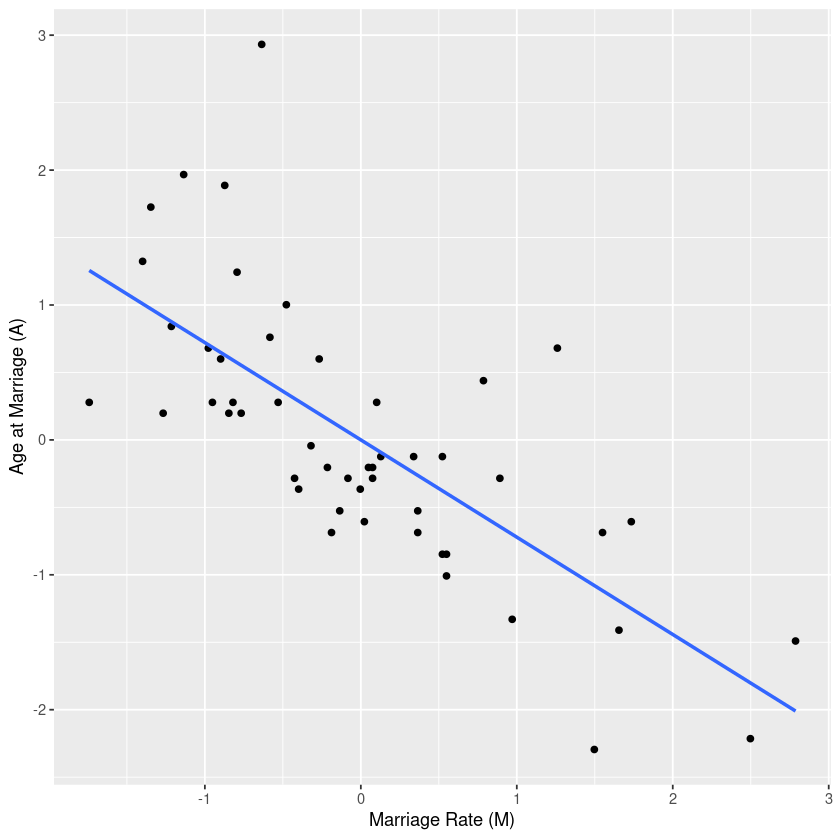

In [22]:
ggplot(plot_df, aes(M, A)) +
    geom_point() +
    geom_smooth(method='lm', formula='y~x', se=FALSE) +
    xlab("Marriage Rate (M)") +
    ylab("Age at Marriage (A)")

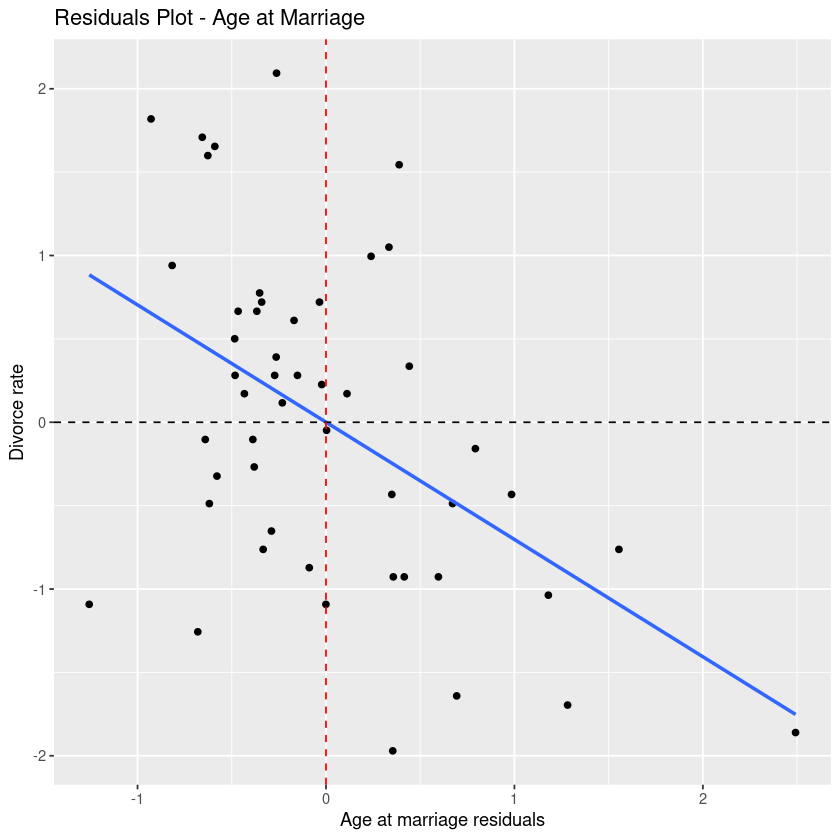

In [23]:
# Age at Marriage Residuals
m5.4.a <- quap( # first we come up with the model - predict A using M
    alist(
        A ~ dnorm(mu, sigma),
        mu <- a + bMA * M,
        a ~ dnorm(0, 0.2),
        bMA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
mu <- link(m5.4.a) # link and find means so we can subtract them out
mu_mean <- apply(mu, 2, mean)
mu_resid <- d$A - mu_mean
plot_df$mu_resid_a <- mu_resid

ggplot(plot_df, aes(mu_resid_a, D)) + # plot the results
    geom_point() + 
    geom_smooth(method='lm', se=FALSE, formula=y ~ x) + 
    geom_hline(yintercept=0, linetype=2) +
    geom_vline(xintercept=0, linetype=2, colour='red') +
    xlab("Age at marriage residuals") +
    ylab('Divorce rate') + 
    ggtitle('Residuals Plot - Age at Marriage')

Here the story is different. States to the right of the red dashed line (residual=0) have a *greater than expected* age at marriage, while those to the left have a *lower than expectd* age at marriage. This shows that, after controlling for the other variables (in this case, marriage rate), there is still an effect.

What's the point? There a conceptual value in seeing the model-based prediction against the outcome, *after* subtracting out the influence of other variables. The procedure also brins home the message that regression models measure the remaining association of each predictor with the outcome, after already knowing the other predictors.

In computing the residuals, we had to compute those predictions ourselves.

Linear regression models do all of thise measuremenent with a very specific additive model how how the variables relate to one another. However, the variables can be related in other ways!

---
Residuals are parameters, not data

In parts of biology, there's a tradition of using residuals as data for use in the next part of the analysis (e.g. regress brain size on body size and then use the residuals in another model). This is always wrong; the correct approach would be to include it in the same model (control for it). Residuals are parameters - variables with unobserved values. Treating them like known values throws away uncertainty.

---

#### Posterior Prediction Plots

It's important to check the model's predictions against the data. 
1. Did the model correctly approximate the posterior distrbution? Sometimes we make mistakes; it can be easier to diagnose by comparing the predictions to the actual outcomes. Not all models attempt the exactly match the sample, but you should be aware of this when you create the model.
1. How does the model fail? Models are 'useful fictions' - they all fail sometimes. By looking at where and how it fails, you might get an idea of where it applies, where it doesn't, and maybe a way to make it better. This is essentially a creative act and must be treated with caution.

How can we produce a simple posterior predictve check in the divorce case? Let's begin by simulating predictions, averaging over the posterior.

In [24]:
# call link w/o specifying new data -> use original data
mu <- link(m5.3)

# summarize samples across means
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)

# simulate observations
# again: no new data, so uses the original data
D_sim <- sim(m5.3, n=1e4)
D_PI <- apply(D_sim, 2, PI, prob=0.5)

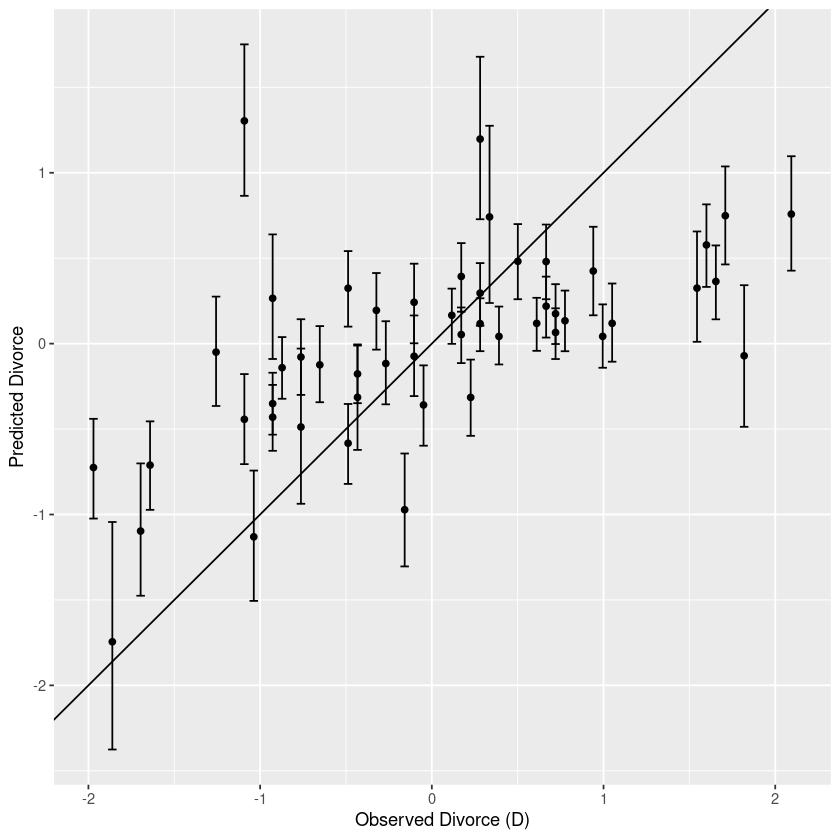

In [25]:
plot_df <- data.frame(
    mu_mean=mu_mean,
    D=d$D,
    lower=mu_PI[1,], # Why are we using mu_PI here? I would have used D_PI, since it's predicted 
    upper=mu_PI[2,] # In fact, we're not using the simulated values at all...
)
ggplot(plot_df, aes(D, mu_mean)) +
    geom_point() +
    geom_abline(intercept=0, slope=1) +
    geom_errorbar(aes(ymin=lower, max=upper)) +
    xlab("Observed Divorce (D)") +
    ylab("Predicted Divorce")

NB The horizontal line is observed = predicted

The model under-predicts for states with high divorce rates but over-predicts for ones with low divorce rates. In some ways this is normal - regression tends to predict close to the mean.

Beyond this, some states are frustrating - Idaho and Utah (ones with the highest predicted divorce rate). Possibly this is because both states have large populations of Mormons, who tend to have a very low divorce rate. This is a way that our model has failed, and suggests that finer-grained demographic data on the composition of each state would help.

---
Often people want statistical modelling to do things that they can't. For example: is an effect 'real' or spurious. Modelling merely quantifies uncertainty in the precise way that the model understands the problem. Usually answers to 'large world' problems abou truth and causation depend on information not included in the model. For instance, and observed correlation could be eliminated once we add another predictor, but if we never think of using that predictor we might not notice.

All statistical models are vulnerable to and demand critique, regardless of the precision of their estimates and apparent accuract of theur redictions. Rounds of model criticism and revision embody the real tests of scientific hypotheses. A true hypothesis will pass and fail many statistical 'tests' on the way to acceptance.

---

---
One way that spurious associations between a predictor and oucame can arise when a truly causal predictor ($x_{real}$) influences both the outcome and the spurious predictor ($x_{spur}$). Here's a very basic simulation:

In [26]:
N <- 1000
x_real <- rnorm(N)
x_spur <- rnorm(N, x_real) # Gaussian with mean=x_real
y <- rnorm(N, x_real) # outcome with mean x_real
d <- data.frame(y, x_real, x_spur)

There is a correlation between the outcome $y$ and $x_{spur}$. However, if you regress $y$ on both $x_{real}$ and $x_{spur}$, the correlation for $x_{spur}$ will be very close to 0.

---

#### Counterfactual Plots

A second sort of inferential plot displays the causal implications of the model. These are called **counterfactual** plots because the can be produced for any values of the predictor variables, even ones that don't appear in the data. For instance, we can ask about states with high divorce rates and high median ages at marriage, even though there are no such states in our data. Or: "What would Utah's divorce rate be if its median age at marriage we higher?". Counterfactual plots can help you undersand the model as well as generate predictions for imaginary interventions and compute how much some observed outcome can be attributed to some cause.

The term 'counterfactual' is used in many diffrent contexts and can mean different things depending on the author. Here, it means some coputation that makes use of the structureal causal model, going beyond the posterior distribution.

Simplest use of a counterfactual: see how the outcome would change as you change one predictor at a time. If $X$ took on a new value for one or more casees, how would outcome $Y$ change? E.g. if we pay people to postpone marriage until 35 - surely this will decrease the number who get married, affecting the marriage rate. But just how much?

Basic recipe:
1. Pick a variable to manipulate - the *intervention variable*
1. Define the range of values to set the intervention variable to
1. For each value of the intervention variable, and for each sample in the posterior, use the causal model to simulate the values of other variables, including the outcome.

Take the following DAG:

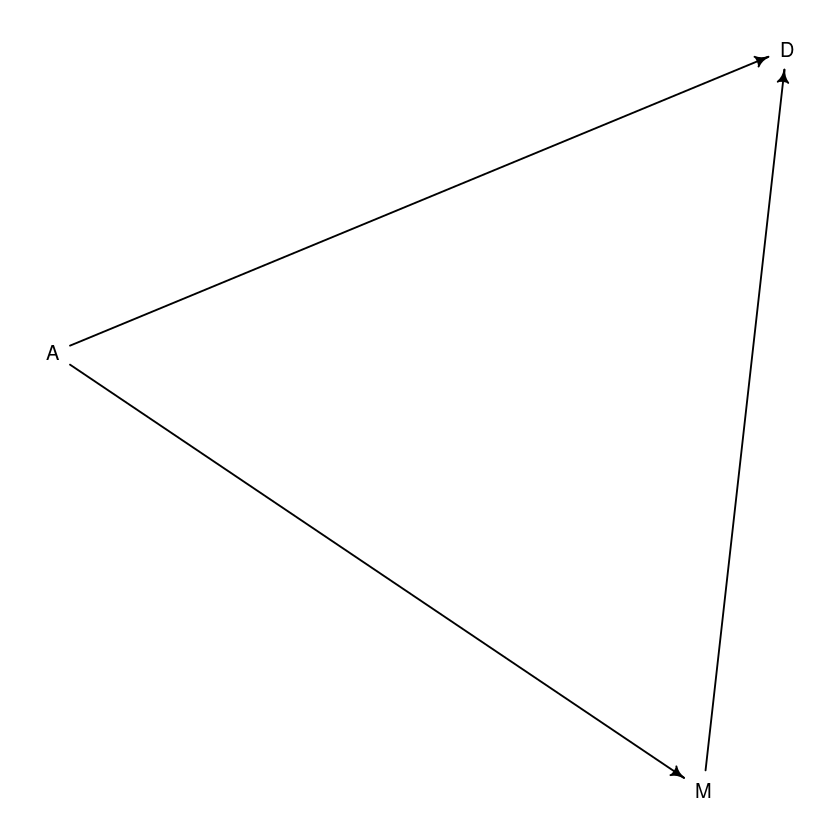

In [27]:
drawdag(dag5.1)

IN addition to the DAG, we also need the function that tells us how each variable affects the others. We'll use the Gaussian, like in `m5.3`, but we'll also add in the effect of A -> M.

To estimate the influence of `A` on `M`, we need to regress `A` on `M`. We'll add this regression to the `quap` model, running two regressions at the same time.

In [28]:
data(WaffleDivorce)
d <- list()
d$A <- standardize(WaffleDivorce$MedianAgeMarriage)
d$D <- standardize(WaffleDivorce$Divorce)
d$M <- standardize(WaffleDivorce$Marriage)

m5.3_A <- quap(
    alist(
        ## A -> D <- M
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1),
        
        ## A -> M
        M ~ dnorm(mu_M, sigma_M),
        mu_M <- aM + bAM * A,
        aM ~ dnorm(0, 0.2),
        bAM ~ dnorm(0, 0.5),
        sigma_M ~ dexp(1)
    ),
    data=d
)

precis(m5.3_A)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,3.756715e-07,0.09707614,-0.1551460,0.1551468
bM,-6.538305e-02,0.15077323,-0.3063478,0.1755817
bA,-6.135155e-01,0.15098376,-0.8548167,-0.3722143
sigma,7.851191e-01,0.07784368,0.6607099,0.9095284
aM,-2.137120e-07,0.08684773,-0.1387997,0.1387992
bAM,-6.947375e-01,0.09572679,-0.8477274,-0.5417476
sigma_M,6.817358e-01,0.06757980,0.5737303,0.7897414


Looking at the `precis`, we can see from the value of `bAM` that `M` and `A` are strongly negatively correlated.

We want to see what happens when we manipulate `A`:

In [29]:
A_seq <- seq(from=-2, to=2, length.out=30)

# prep data
sim_dat <- data.frame(A=A_seq)

# simulate M *and then* D, using A_seq - the vars argument tells it both which observales to simhlate and in which order
s <- sim(m5.3_A, data=sim_dat, vars=c("M", "D"))

In [30]:
PI_D <- apply(s$D, 2, PI)
plot_df <- data.frame(A=sim_dat$A, D_means=colMeans(s$D), lower_D=PI_D[1,], upper_D=PI_D[2,])

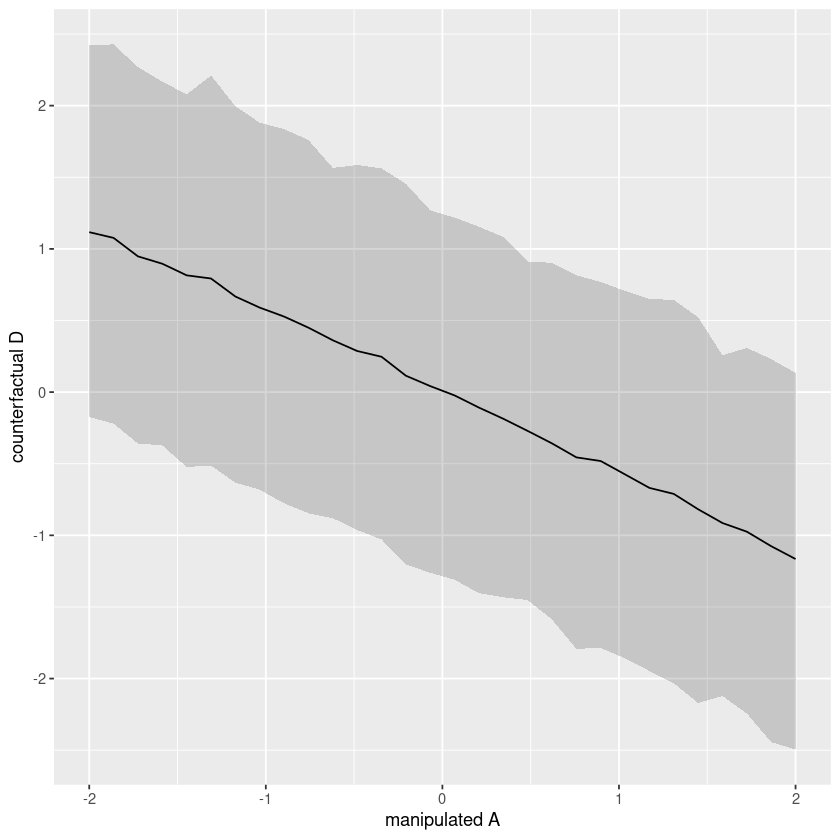

In [31]:
ggplot(plot_df, aes(A, D_means)) +
    geom_ribbon(aes(x=A, ymin=lower_D, ymax=upper_D), alpha=0.2) +
    geom_line() +
    xlab("manipulated A") +
    ylab("counterfactual D")

This predicted trned in `D` includes both paths (A -> D and A -> M -> D). We previously found that M -> D is small, so most of this effect is A -> M -> D.

The counterfactual imulations also generated values for `M`:

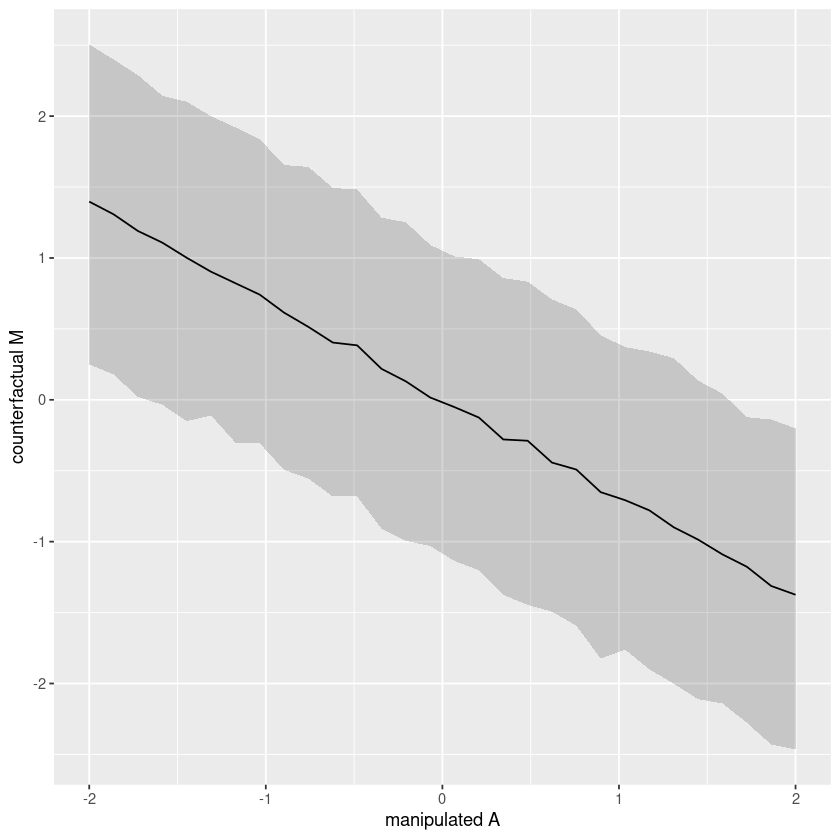

In [32]:
plot_df$M_means=colMeans(s$M)
PI_M = apply(s$M, 2, PI)
plot_df$lower_M = PI_M[1,]
plot_df$upper_M = PI_M[2,]

ggplot(plot_df, aes(A, M_means)) +
    geom_ribbon(aes(x=A, ymin=lower_M, ymax=upper_M), alpha=0.2) +
    geom_line() +
    xlab("manipulated A") +
    ylab("counterfactual M")

Of course, we can also come up with numerical summaries of the data. For instance, expected causal effect of increasing the median age at marriage from 20 -> 30:

In [33]:
# new data frame, standardized to mean 26.1 and std dev 1.24
sim2_dat <- data.frame(A=(c(20,30) - 26.1) / 1.24)
s2 <- sim(m5.3_A, data=sim2_dat, vars=c("M", "D"))
mean(s2$D[,2] - s2$D[,1])

[1] -4.546999

This tells us that making such an intervention would have an effect on the divorce rate of -4.5 standard deviations, which is probably impossibly huge.

When simulating a counterfactual and manipulating a variable $X$, we brek the causal influence over other variables on $X$. Basically: we are modifying the DAG so that no arrows enter $X$. For instance, if we simulate the effect of manipulating $M$ -> implies the DAG

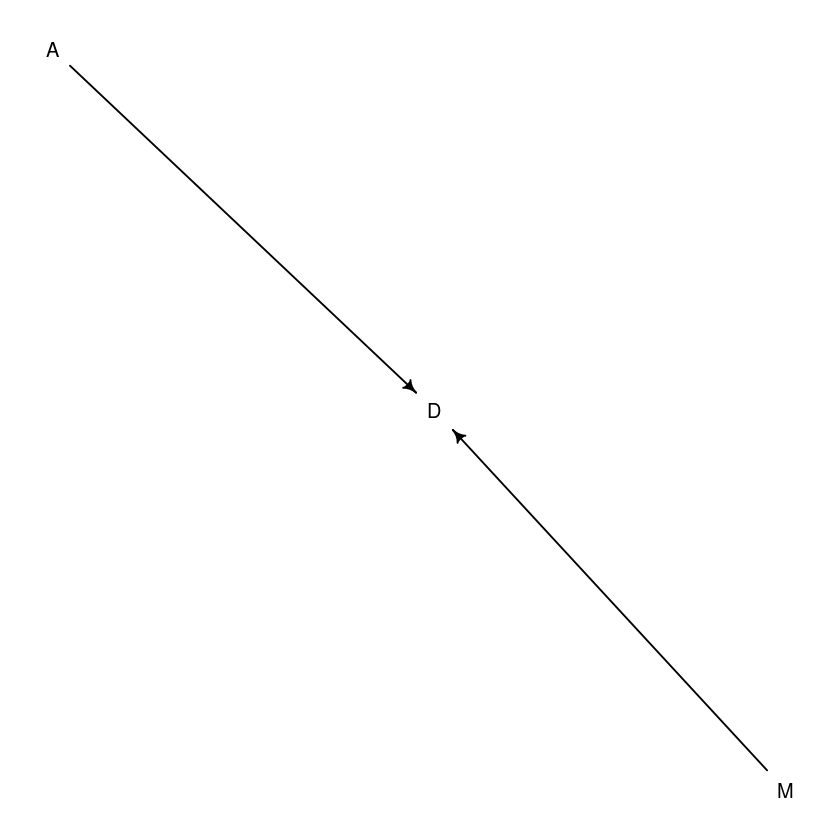

In [34]:
counterfactual <- dagitty("dag{A->D; M->D}")
drawdag(counterfactual)

The A -> M arrow is deleted because if we control $M$, then $A$ can no longer influence it - a perfectly controlled experiment!

Counterfactual to simulate manipulating $M$ for an average state with $A=0$ and see what changing $M$ does

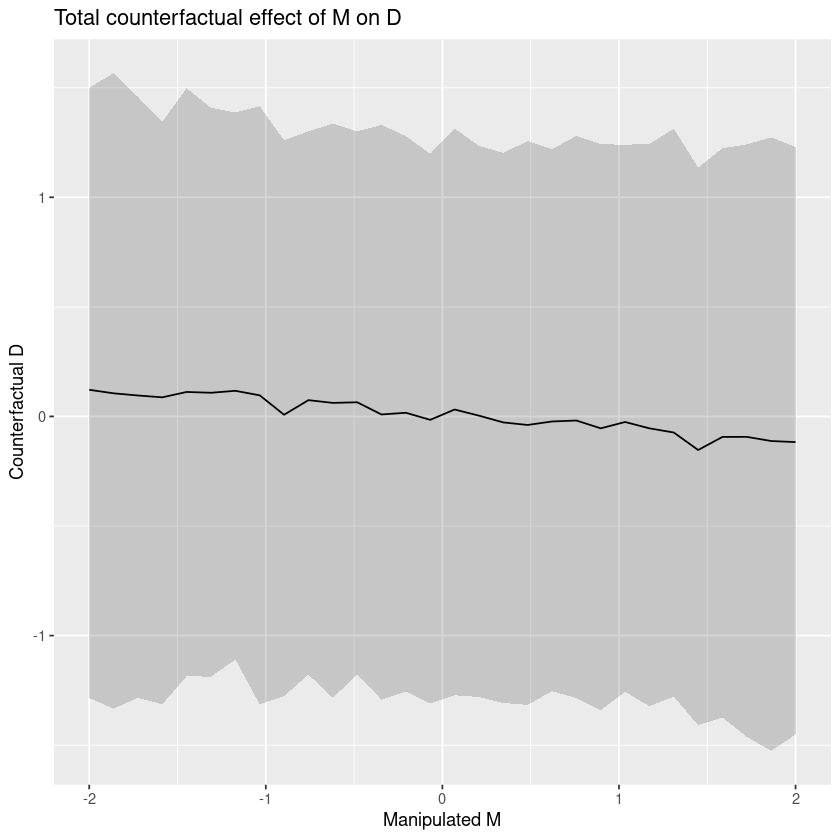

In [35]:
sim_data <- data.frame(M=seq(from=-2, to=2, length.out=30), A=0)
s <- sim(m5.3_A, data=sim_data, vars="D")
PI <- apply(s, 2, PI)

plot_df <- data.frame(M=sim_data$M, means=colMeans(s), lower=PI[1,], upper=PI[2,])
ggplot(plot_df, aes(M, means)) +
    geom_ribbon(aes(x=M, ymin=lower, ymax=upper), alpha=0.2) +
    geom_line() +
    xlab("Manipulated M") +
    ylab("Counterfactual D") +
    ggtitle("Total counterfactual effect of M on D")

Note that we only simulate D, not A - M no longer influences it. Notice that the trend is much less strong - there's no evidence  for a strong influence of M and D

In more complex models with different paths, the same strategy will computer counterfactuals for an exposure of interest. However, it can somtimes not be possible to estimate a plusible, un-confounded causal effect of some exposure X and an outcome Y. But even in those cases ,there are still important counterfactuals to consider.

---

Overthinking simulating counterfactuals

Apparently it's not that hard to run the simulation yourself!

---

## Masked Relationships

As we saw: multiple predictor variables are useful for finding spurious correlations. Another reason: measure the direct inflyence of multiple factors on an outcome whene none of those influeces is apparent from a bivariate relationship. This can happen when e.g. two predictor variables influence an outcome, but one does so positively and the other negatively.

New data context: information about the composition of milk across primate species, as well as some facts about those species (e.g. body and brain size).

In [36]:
data(milk)
d <- milk
str(d)

'data.frame':	29 obs. of  8 variables:
 $ clade         : Factor w/ 4 levels "Ape","New World Monkey",..: 4 4 4 4 4 2 2 2 2 2 ...
 $ species       : Factor w/ 29 levels "A palliata","Alouatta seniculus",..: 11 8 9 10 16 2 1 6 28 27 ...
 $ kcal.per.g    : num  0.49 0.51 0.46 0.48 0.6 0.47 0.56 0.89 0.91 0.92 ...
 $ perc.fat      : num  16.6 19.3 14.1 14.9 27.3 ...
 $ perc.protein  : num  15.4 16.9 16.9 13.2 19.5 ...
 $ perc.lactose  : num  68 63.8 69 71.9 53.2 ...
 $ mass          : num  1.95 2.09 2.51 1.62 2.19 5.25 5.37 2.51 0.71 0.68 ...
 $ neocortex.perc: num  55.2 NA NA NA NA ...


We'll specifically be looking at `kcal.per.g` (kilocalories per gram of milk), `mass` (average female body mass), and `neocortex.perc`, percent of total brain mass that is neocortex mass)

Popular hypothesis: larger brains -> more energetic milk.

In [37]:
# standardize
d$K <- standardize(d$kcal.per.g)
d$N <- standardize(d$neocortex.perc)
d$M <- standardize(log(d$mass))

First model: simple bivariate regression of kcal and neocortex percent.

$$
\begin{align*}
K_i &\sim \text{Normal}(u_i, \sigma) \\
\mu_i &\sim \alpha + \beta_N N_i \\
\end{align*}
$$

In [38]:
m5.5_draft <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bN * N,
        a ~ dnorm(0, 1),
        bN ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=d
)

ERROR: Error in quap(alist(K ~ dnorm(mu, sigma), mu <- a + bN * N, a ~ dnorm(0, : initial value in 'vmmin' is not finite
The start values for the parameters were invalid. This could be caused by missing values (NA) in the data or by start values outside the parameter constraints. If there are no NA values in the data, try using explicit start values.


What is this error message? Model was unable to provide a valid probability even for the starting parameter values. In this case: missing data from the N variable.

In [39]:
d$neocortex.perc

[1] 55.16    NA    NA    NA    NA 64.54 64.54 67.64    NA 68.85 58.85 61.69
[13] 60.32    NA    NA 69.97    NA 70.41    NA 73.40    NA 67.53    NA 71.26
[25] 72.60    NA 70.24 76.30 75.49

Bunch of NAs! Means that the probabilities can't be calculated.

Easy fix: drop all of the cases with NA. This is called **complete case analysis**. It's not always a good thing - for instance, if you are comparing different models, you have to be sure that they have the same data!

(But we'll go with it for now).

In [40]:
# make a new dataframe with the rows that aren't missing any data
dcc <- d[complete.cases(d$K, d$N, d$M),]

# recalculate the model just using the complete cases
m5.5_draft <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bN * N,
        a ~ dnorm(0, 1),
        bN ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=dcc
)

Priors: are they reasonable? Let's simulate and plot 50 regression lines.

In [41]:
prior <- extract.prior(m5.5_draft)
xseq <- c(-2,2)
mu <- link(m5.5_draft, post=prior, data=list(N=xseq))
head(mu)
# mu holds the values of mu for each value of seq (so the first row is a sample of mu at -2 and 2
# and so is the second, &c.
# so we have 1000 samples

1.1092830,-1.9223412
-1.3475958,-1.6916545
1.1960527,0.1577147
0.3298431,-0.2221255
0.1035488,-0.1476333
-5.1590129,3.0036279


In [42]:
# to plot this, we need to divvy it up into N (x) and K (y) components, and then group them
# so that we can connect them with a line later
plot_df <- data.frame(matrix(nrow=0, ncol=3))
colnames(plot_df) <- c("N", "K", 'grp')
# now add in data - for each row in mu we add two points and one group
for (i in 1:50) {
     # i is the group number
     plot_df[nrow(plot_df) + 1,] <- c(N=xseq[1], K=mu[i,1], grp=i)
     plot_df[nrow(plot_df) + 1,] <- c(xseq[2], mu[i,2], i)
}

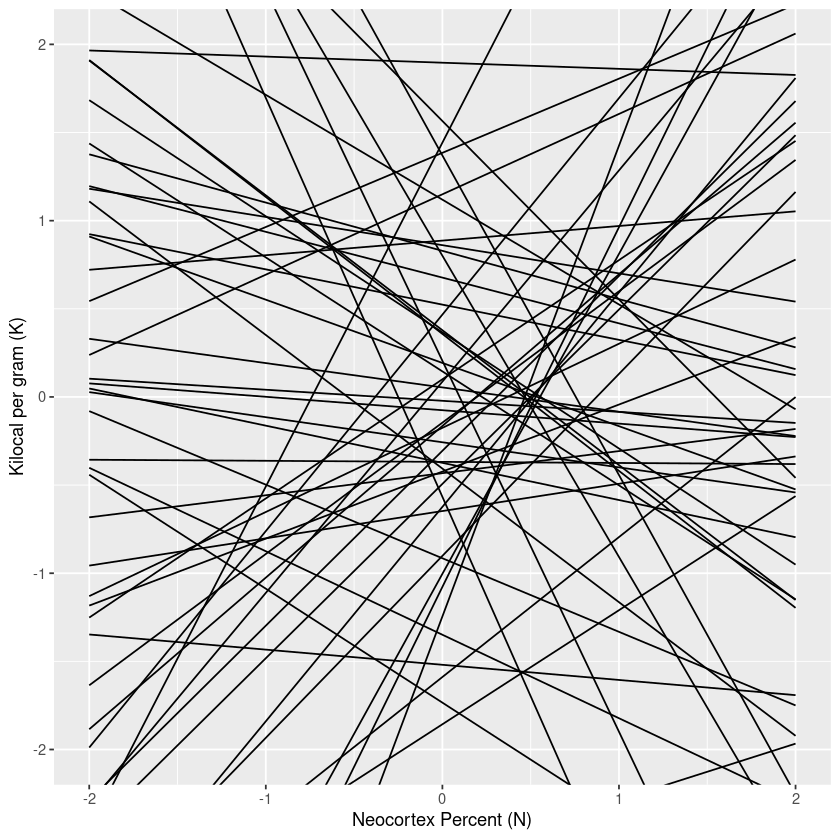

In [43]:
ggplot(plot_df, aes(N, K, group=grp)) +
    geom_line() +
    coord_cartesian(ylim=c(-2,2), xlim=c(-2,2)) +
    xlab("Neocortex Percent (N)") +
    ylab("Kilocal per gram (K)")

This is clearly some nonsense. As in previous exaples, we can tighten the $\alpha$ prior so that it sticks cloer to zero. The slope $\beta_N$ also needs to be tightened so that it doesn't regularlt produce impossibly strong relationships.

In [44]:
m5.5 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bN * N,
        a ~ dnorm(0, 0.2),
        bN ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=dcc
)

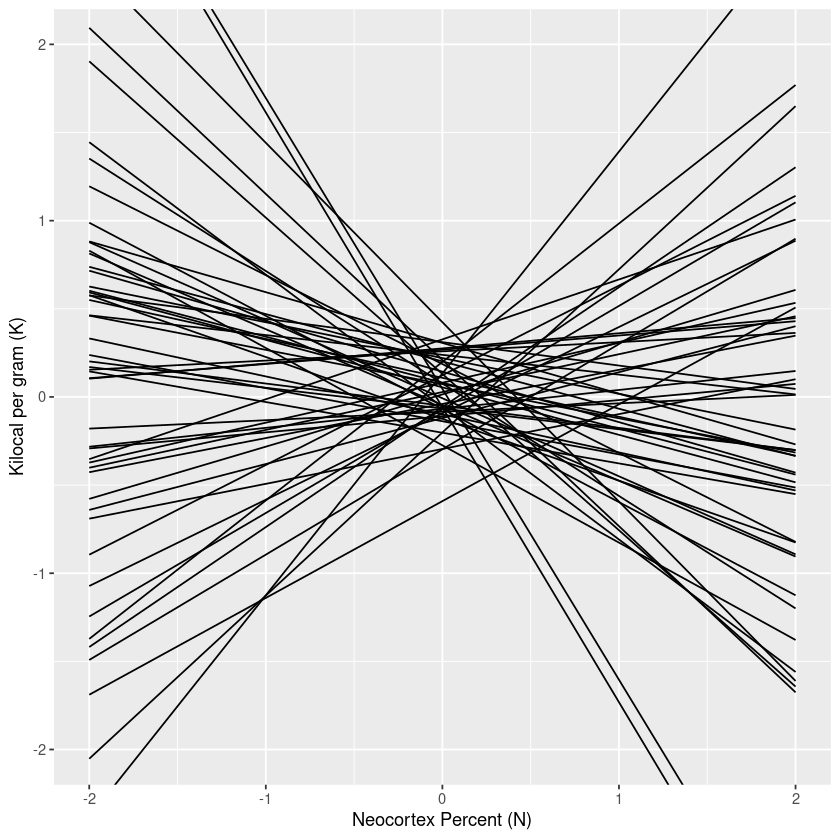

In [45]:
prior <- extract.prior(m5.5)
xseq <- c(-2,2)
mu <- link(m5.5, post=prior, data=list(N=xseq))

plot_df <- data.frame(N=double(), K=double(), grp=integer())
# now add in data - for each row in mu we add two points and one group
for (i in 1:50) {
     # i is the group number
     plot_df[nrow(plot_df) + 1,] <- c(N=xseq[1], K=mu[i,1], grp=i)
     plot_df[nrow(plot_df) + 1,] <- c(xseq[2], mu[i,2], i)
}
ggplot(plot_df, aes(N, K, group=grp)) +
    geom_line() +
    coord_cartesian(ylim=c(-2,2), xlim=c(-2,2)) +
    xlab("Neocortex Percent (N)") +
    ylab("Kilocal per gram (K)")

This seems slightly more reasonable!

Now onto the posterior:

In [46]:
precis(m5.5)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.03982207,0.1544926,-0.2070870,0.2867311
bN,0.13328398,0.2237494,-0.2243108,0.4908788
sigma,0.99983745,0.1647142,0.7365923,1.2630826


We can see that there's not a strong or precise relationship - sigma is (apparently) twice the posterior mean (???)

Let's graph it instead

In [47]:
xseq <- seq(from=min(dcc$N) - 0.15, to=max(dcc$N) + 0.15, length.out=30)
mu <- link(m5.5, data=list(N=xseq))
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)

plot_df <- data.frame(mu_mean=mu_mean, lower=mu_PI[1,], upper=mu_PI[2,])

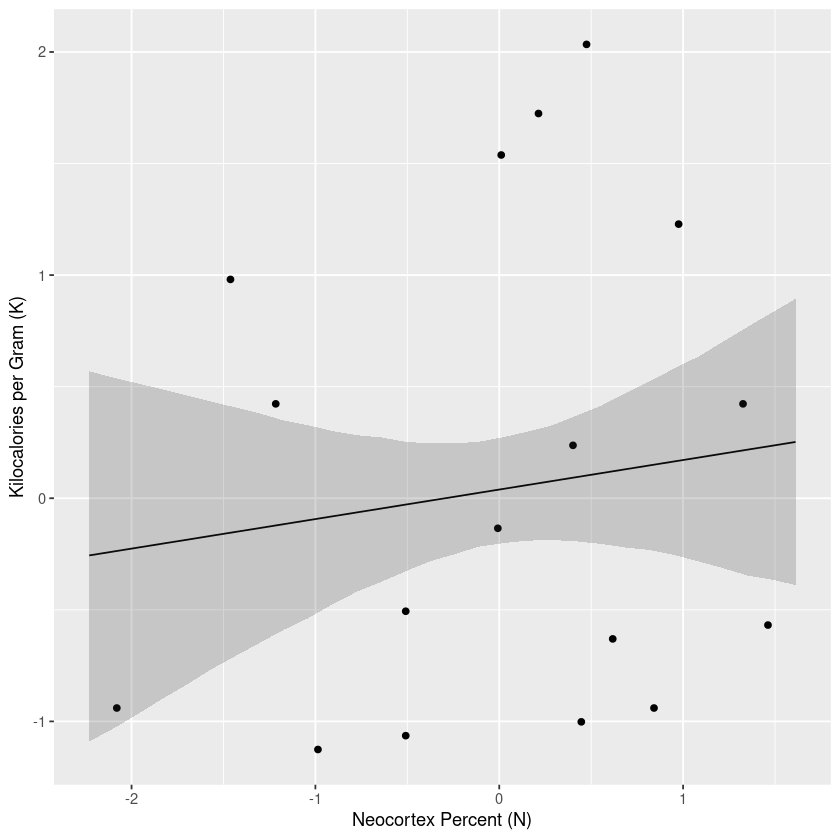

In [48]:
ggplot() +
    geom_point(dcc, mapping=aes(x=N, y=K)) +
    geom_line(data.frame(xseq=xseq, mu_mean=mu_mean), mapping=aes(x=xseq, y=mu_mean)) +
    geom_ribbon(data.frame(xseq=xseq, lower=mu_PI[1,], upper=mu_PI[2,]), mapping=aes(x=xseq, ymin=lower, ymax=upper), alpha=0.2) +
    xlab("Neocortex Percent (N)") +
    ylab("Kilocalories per Gram (K)")

So here we're seeing a positive relationship, but a pretty weak one - there's a lot of imprecision

Consider another variable: mother's mass. We'l take the logarithm - stuff like this is often related to the *megnitude* of a scaling variable (like mass). Let's construct another model, but using this variable

In [49]:
m5.6 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=dcc
)

In [50]:
precis(m5.6)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.04654203,0.1512800,-0.1952327,0.2883167
bM,-0.28253568,0.1928818,-0.5907981,0.0257267
sigma,0.94927946,0.1570616,0.6982648,1.2002942


The log of mass seems to be negatively correlated with kilocalories, although again there's a lot of uncertainty. Let's graph it to see

In [51]:
mseq <- seq(from=min(dcc$M) - 0.15, to=max(dcc$M) + 0.15, length.out=30)
mu <- link(m5.6, data=list(M=mseq))
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)

line_df <- data.frame(M=mseq, K=mu_mean)
shade_df <- data.frame(M=mseq, lower=mu_PI[1,], upper=mu_PI[2,])

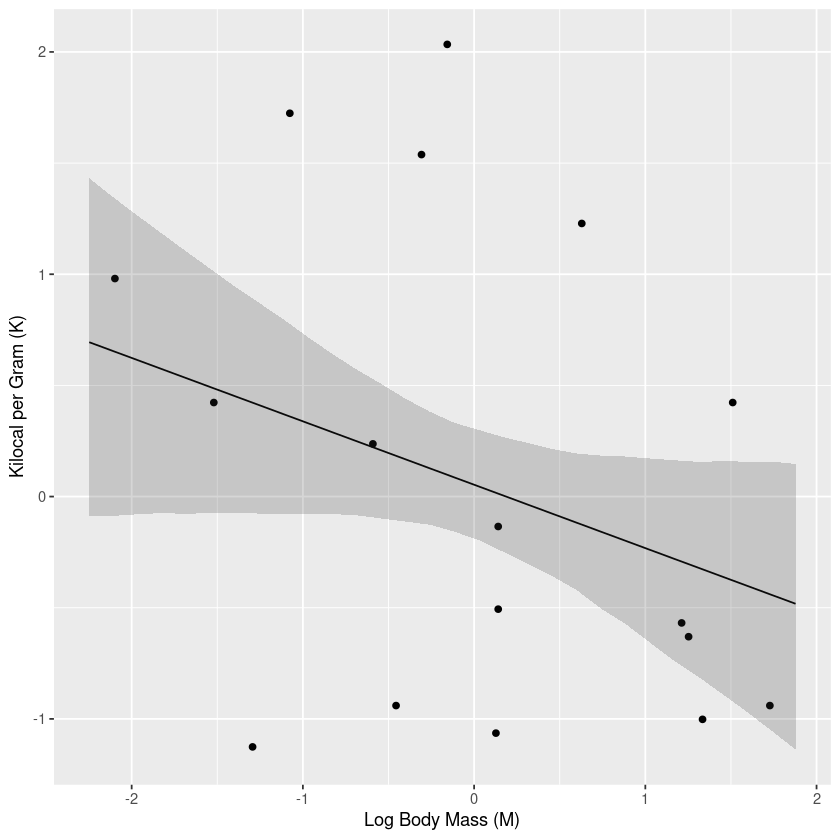

In [52]:
ggplot() +
    geom_point(dcc, mapping=aes(M, K)) +
    geom_line(line_df, mapping=aes(M, K)) +
    geom_ribbon(shade_df, mapping=aes(x=M, ymin=lower, ymax=upper), alpha=0.2) +
    xlab("Log Body Mass (M)") +
    ylab("Kilocal per Gram (K)")

Now let's see what happens when we add both variables:

$$
\begin{align*}
K_1 &\sim \text{Normal}(\mu_i, sigma) \\
\mu_I &= \alpha + \beta_N N_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_N &\sim \text{Normal}(0,0.5) \\
\beta_M &\sim \text{Normal}(0,0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [53]:
m5.7 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bN * N + bM * M,
        a ~ dnorm(0, 0.2),
        bN ~ dnorm(0, 0.5),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=dcc
)

In [54]:
precis(m5.7)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.0679915,0.1339987,-0.1461642,0.2821473
bN,0.6751183,0.2482985,0.2782894,1.0719472
bM,-0.7029907,0.2207870,-1.0558509,-0.3501304
sigma,0.7380140,0.1324617,0.5263146,0.9497135


BY including both variables, their association with the outcomes hav become stronger!

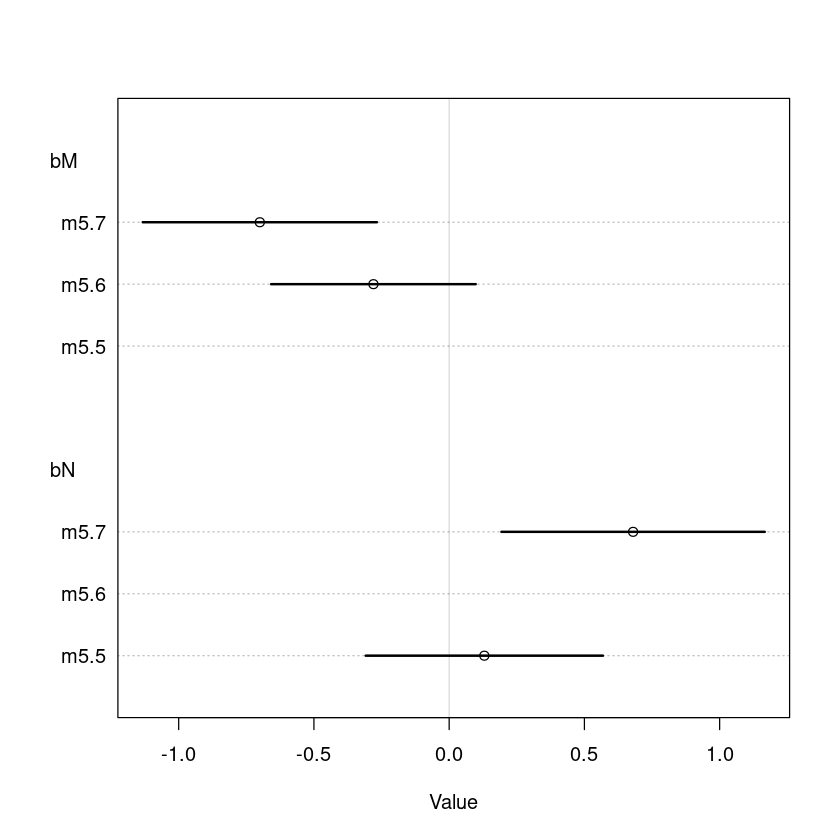

In [55]:
plot(coeftab(m5.5, m5.6, m5.7), pars=c("bM", "bN"))

Adding *both* variables to the model moved both of their posterior means away from zero! Why did this happen?

- Both variables are correlated with the outcome, but one positively and on negatively
- Both variables are correlated with each other (see below)

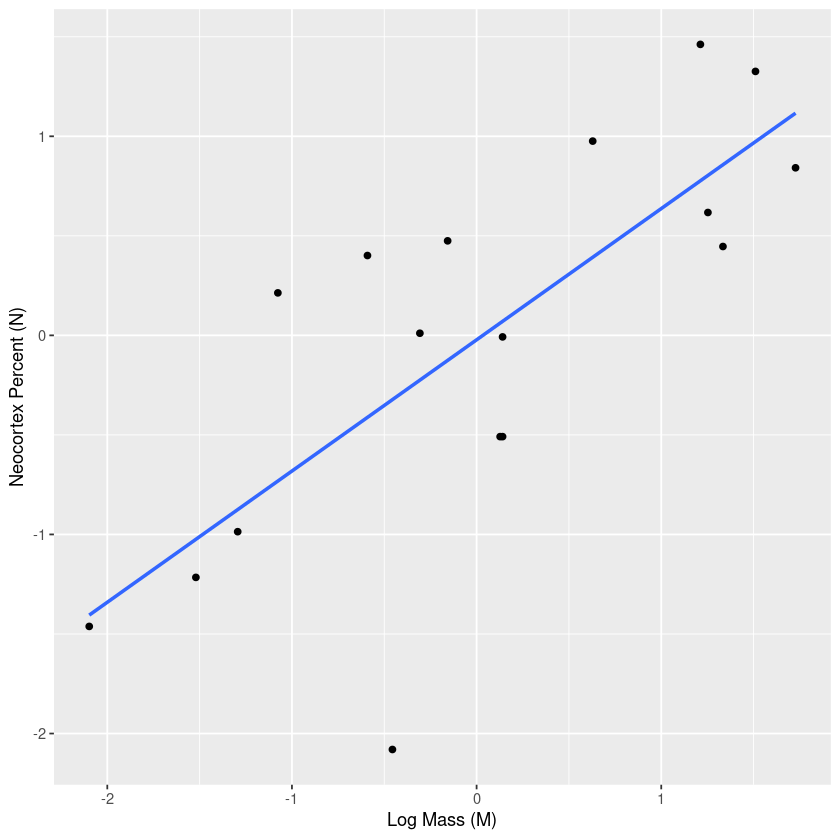

In [56]:
ggplot(dcc, aes(M, N)) +
    geom_point() +
    xlab("Log Mass (M)") +
    ylab("Neocortex Percent (N)") + 
    geom_smooth(method="lm", formula="y ~ x", se=FALSE)

End result: they tend to cancel each other out.

Multiple regression allowed us to pick out the most revealing cases: ask if species with have a high neocortex percent *for their boy mass* have a higher milk energy, or similarly, whether species with high body mass *for their neocortex percent* have a higher milk energy.

Bigger species, like apes, have milk with less energy. But also, species with more neocortex tend to hav richer milk. The fact that these two variables are correlated across species makes it hard to see these relationsips unless we account for both.

There are at least three DAGs consistent with the data:

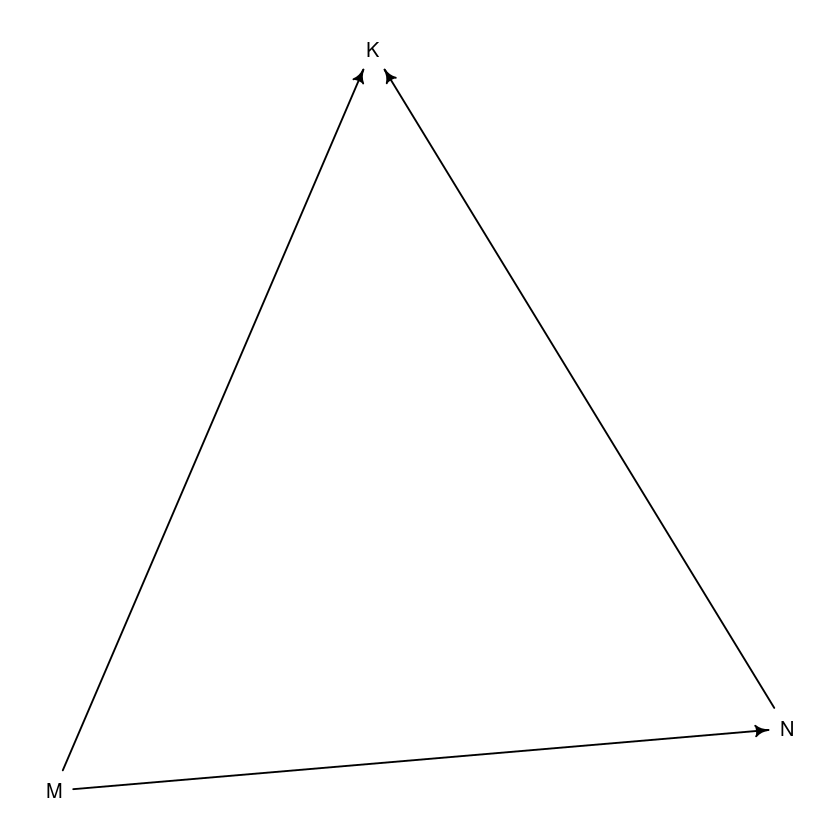

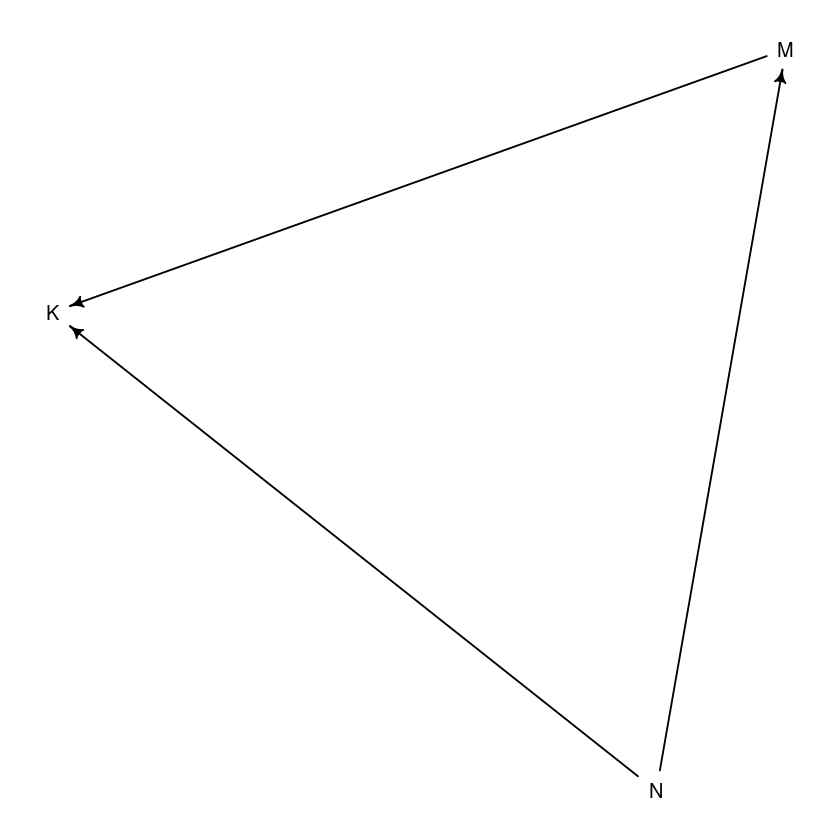

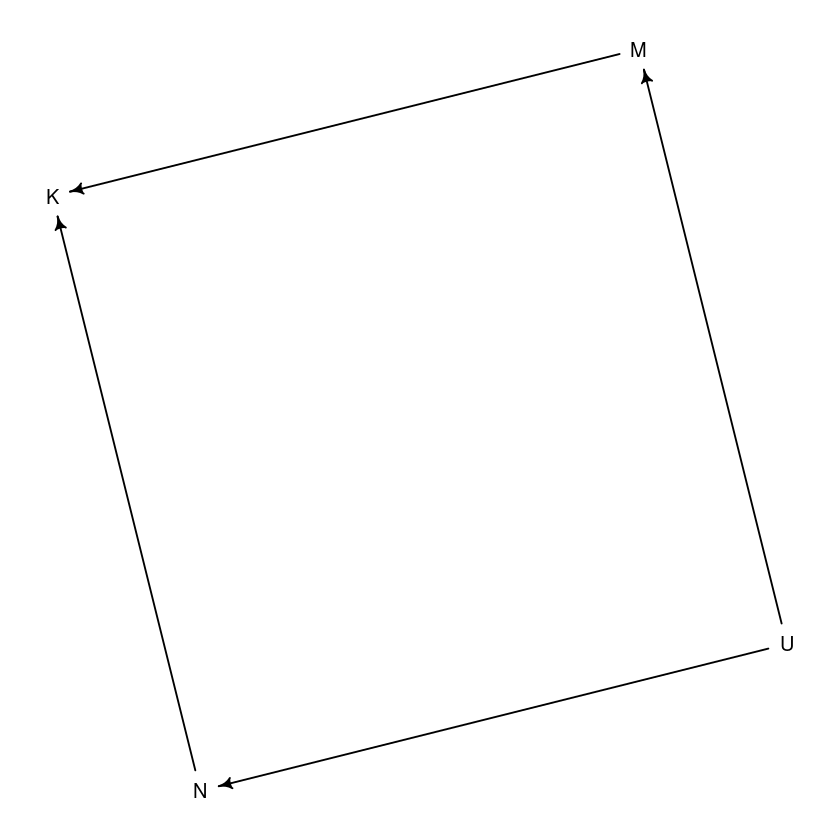

In [57]:
dag1 <- dagitty("dag{M->K; M->N; N->K}")
dag2 <- dagitty("dag{N->M; N->K; M->K}")
dag3 <- dagitty('dag{
U[pos="0,2"]
U->M; U->N; N->K; M->K}')
drawdag(dag1)
drawdag(dag2)
drawdag(dag3)

Here U is an unobserved variable that is influencing both M and N

So, which on is it? It turns out that we can't tell! All of these imply the same set of conditional independencies. In this cases - none (each DAG implies that all sets of variables are associated. A set of DAGs with the same set of conditional independencies is called a Markov Equivalence set.

Now let's make some counterfactual plots again. Suppose that the third DAG is correct. Then imagine manipuating M and N, breaking U'd influence. We can't run this experiment in reality, but we can here!

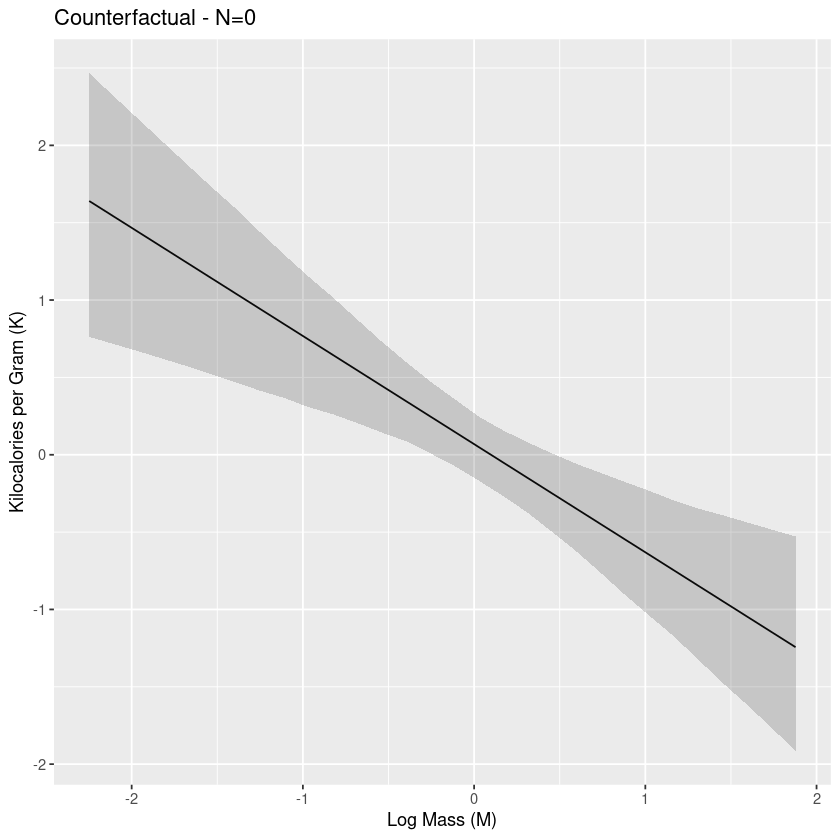

In [58]:
mseq <- seq(from=min(dcc$M) - 0.15, to=max(dcc$M) + 0.15, length.out=30)
mu <- link(m5.7, data=data.frame(M=mseq, N=0))
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)
plot_df <- data.frame(M=mseq, K=mu_mean, lower=mu_PI[1,], upper=mu_PI[2,])

ggplot(plot_df, aes(M, K)) +
    geom_line() +
    geom_ribbon(aes(ymin=lower, max=upper), alpha=0.2) +
    xlab("Log Mass (M)") +
    ylab("Kilocalories per Gram (K)") +
    ggtitle("Counterfactual - N=0")
           

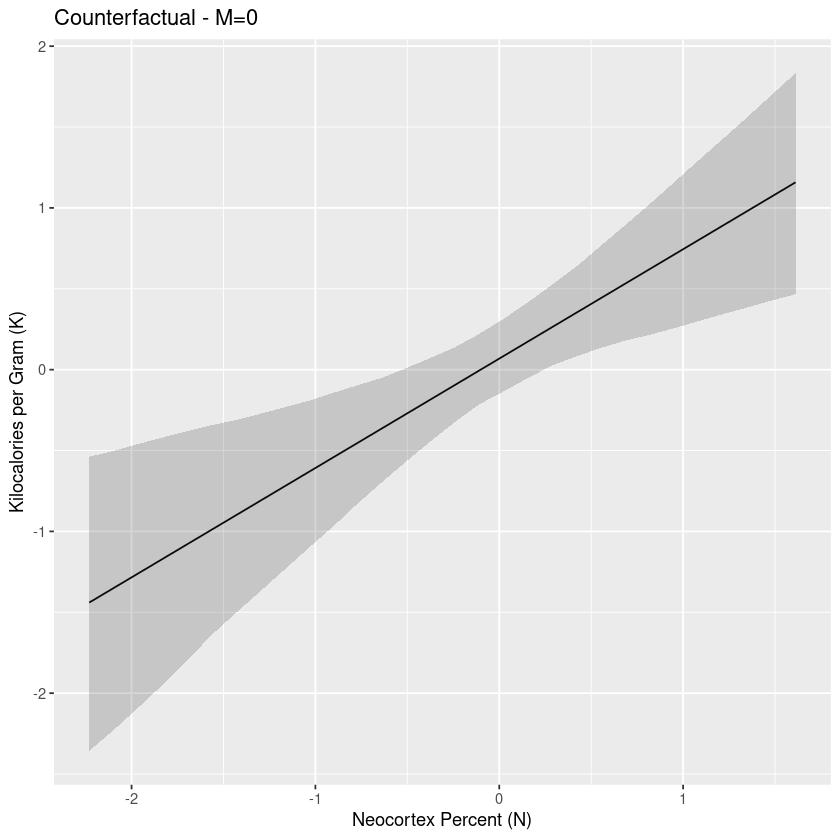

In [59]:
nseq <- seq(from=min(dcc$N) - 0.15, to=max(dcc$N) + 0.15, length.out=30)
mu <- link(m5.7, data=data.frame(M=0, N=nseq))
mu_mean <- apply(mu, 2, mean)
mu_PI <- apply(mu, 2, PI)
plot_df <- data.frame(N=nseq, K=mu_mean, lower=mu_PI[1,], upper=mu_PI[2,])

ggplot(plot_df, aes(N, K)) +
    geom_line() +
    geom_ribbon(aes(ymin=lower, max=upper), alpha=0.2) +
    xlab("Neocortex Percent (N)") +
    ylab("Kilocalories per Gram (K)") +
    ggtitle("Counterfactual - M=0")

## Categorical Variables

Common question: how does an outcome change in the presence / absence of a category? Category: discrete and unordered. FOr instance, in your data we can categorize the species as New World monkeys, apes, &c. How might our predictions change if something were an ape instead of a New World monkey?

Taxonomic group is a *categorical variable* since
- Discreteness: no species can be half-ape or half-monkey
- Unordered: no sense in which one category is larger / smaller than the other

Some other examples:
- Sex: male, female
- Developmental status: infant, juvenile, adult
- Geographic region: Africa, Eruope, Melanesia

Variables like this are often called *factors*.

### Binary categories
In the simplest case: variable has only two values (e.g. male and female). Let's take a look at the Kalahari data:

In [60]:
data(Howell1)
d <- Howell1
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


The `male` variable is called an *indicator* or *dummy* variable. It is a way of encoding categorical variables into a quantitative model. For an indicator variable, it doesn't matter which variable is the 1 and which the 0 - just remember which is which.

Two ways of including this variable. First, we can just use it as a regular variable in the regression:

$$
\begin{align*}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_m m_i \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta_m &\sim \text{Normal}(0, 10) \\
\sigma &\sim \text{Uniform}(0, 50) \\
\end{align*}
$$

(Here $m_i$ is the `male` variable - 1 for a male, 0 for a female). For a male, the model is $\alpha + \beta_m$; for a female, $\alpha$ (since you multiply $b_m$ by 0). In this sense, $\beta_m$ represents the expected difference between males and females. $\alpha$ is now the average female height. This can make finding sensible priors more difficult.

Another consequence is that we implicitly assume that there is more variability in one category (male) - it uses two variables, each with their own uncertainty, while female only uses one.

We can simulate this directly from the priors:

In [61]:
mu_female <- rnorm(1e4, 178, 20)
mu_male <- rnorm(1e4, 178, 20) + rnorm(1e4, 0, 10)
precis(data.frame(mu_female, mu_male))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu_female,177.8764,19.83554,146.0794,209.7428,▁▁▃▇▇▂▁▁
mu_male,178.2443,22.18940,142.9477,213.9297,▁▁▃▇▇▂▁▁


Look at the percentiles - the male one is wider!

In our case it doesn't matter too much - we have lots of data, so the priors will wash out. But in general we should be careful - we don't actually think that there's more variability in the male population, so we shouldn't encode it into our priors.

Another way: using an *index variable*. An index variable contains integers that correspond to different categories. The integers themselves are irrelevant, but they let us encode the information. 


In [62]:
d$sex <- ifelse(d$male == 1, 2, 1)

Then our model is

$$
\begin{align*}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &\sim \alpha_{\text{SEX}[i]} \\
\alpha_j &\sim \text{Normal}(178, 20) & \text{for $j=1\dots2$} \\
\sigma &\sim \text{Uniform}(0, 50) \\
\end{align*}
$$

So now we have a new $\alpha$ variable for each value of the index - each one has the same amount of uncertainty!

Note that we've assigned the same prior to each $\alpha$ - this corresponds to an initial belief that the values are the same. Almost surely not correct, but...

In [63]:
m5.8 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a[sex],
        a[sex] <- dnorm(178, 20),
        sigma ~ dunif(0, 50)
    ),
    data=d
)
precis(m5.8, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],134.91084,1.606930,132.34266,137.47902
a[2],142.57814,1.697468,139.86526,145.29103
sigma,27.30989,0.828037,25.98653,28.63325


We are actually interested in the differences, not the raw values. Let's extract these:

In [64]:
# post is a 'list' containing the variables in our model (1000 of each)
post <- extract.samples(m5.8)

post$diff_fm <- post$a[,1] - post$a[,2]
precis(post, depth=2)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sigma,27.300964,0.833253,25.96601,28.614152,▁▁▁▁▃▇▇▇▃▂▁▁▁
a[1],134.906602,1.619115,132.30986,137.481992,▁▁▁▂▅▇▇▅▂▁▁▁▁
a[2],142.590560,1.680489,139.89682,145.301905,▁▁▁▁▁▃▇▇▇▃▂▁▁▁▁
diff_fm,-7.683958,2.327470,-11.38973,-3.931865,▁▁▁▁▂▇▇▃▁▁▁


This is the expected difference between the male and female heights. This kind of calculation is called a *contrast*.

### Many Categories

Binary categories are easy, whether you using an indicator variable or an index variable. When there is more than one category, the indicator variable approach explodes - you need $n-1$ indicators for $n$ variables.

So, we'll using the index variable approach.

Let's continue to explore the milk example, but now looking at the taxonomic membership:

In [65]:
data(milk)
d <- milk
levels(d$clade)

[1] "Ape"              "New World Monkey" "Old World Monkey" "Strepsirrhine"

We could create the mapping by hand, but coercing the factor to an integer will work just as well:

In [66]:
d$clade_id <- as.integer(d$clade)

Model to measure the average milk energy in each clade:

$$
\begin{align*}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{\text{CLADE}[i]} \\
\alpha_j &\sim \text{Normal}(0, 0.5) & \text{for $j=1\dots 4$} \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

$K$ is the normalized kilocalories. The prior is a little wider to allow the different clades to disperse.

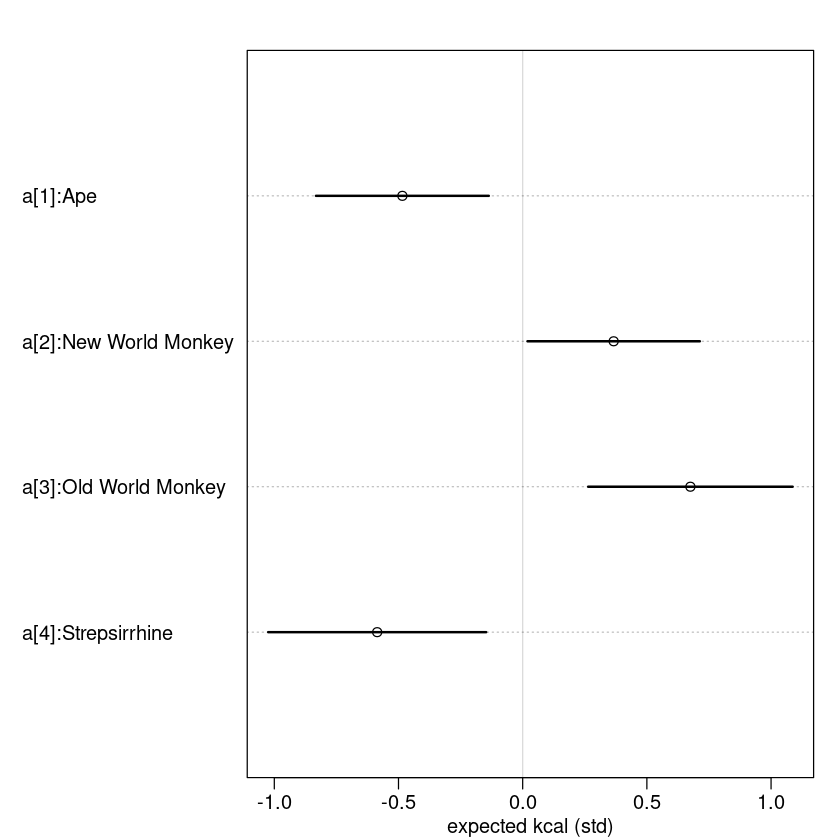

In [67]:
d$K <- standardize(d$kcal.per.g)
m5.9 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a[clade_id],
        a[clade_id] ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
labels <- paste("a[", 1:4, "]:", levels(d$clade), sep="")
plot(precis(m5.9, depth=2, pars="a"), labels=labels, xlab="expected kcal (std)")

Apparently in practice you need to be careful to ensure that the right id goes with the right variable - you can't always trust R's factors to get it right.

If you have another kind of variable you want to add to the model, the approach is the same. For instance, we can assign the primates to houses:

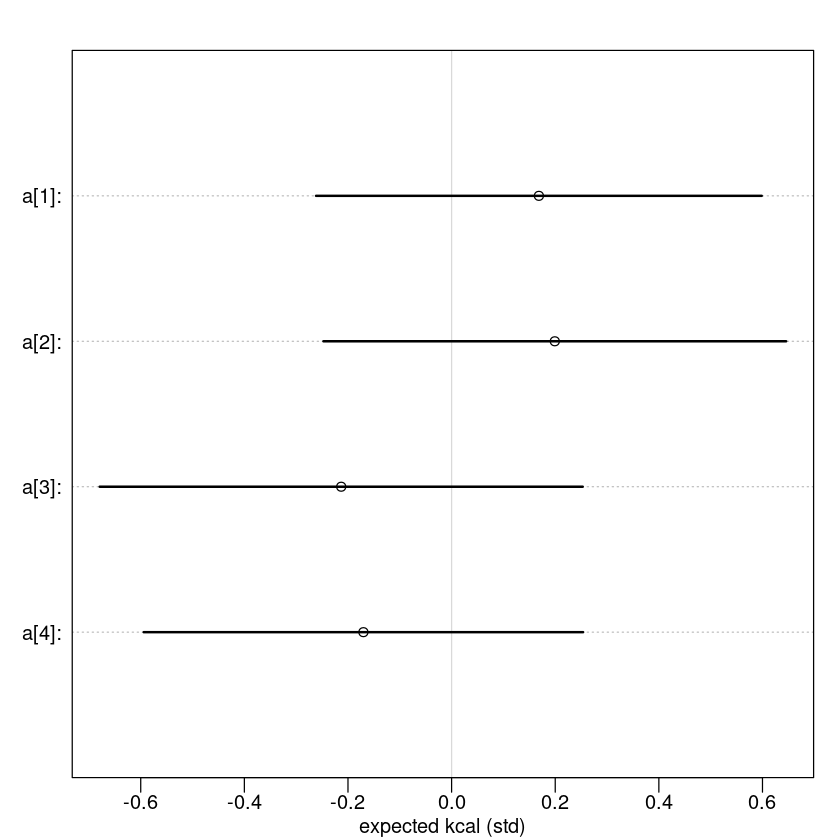

In [68]:
d$house <- sample(rep(1:4, each=8), size=nrow(d))

m5.10 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a[clade_id] + h[house],
        a[clade_id] ~ dnorm(0, 0.5),
        h[house] ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

labels <- paste("a[", 1:4, "]:", levels(d$house), sep="")
plot(precis(m5.10, depth=2, pars="h"), labels=labels, xlab="expected kcal (std)")

---

Common error: assuming that if one variable is sufficiently different from zero ('significant') and another isn't, then their differen ce is significant. Not necessarily the case!

---

## Practice

### Easy

**5E1**: Which of the following are multiple linear regressions?
1. $\mu_i = \alpha + \beta x_i$
2. $\mu_i = \beta_x x_i + \beta_z z_i$
3. $\mu_i = \beta(x_i - z_i)$
4. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$


**Answer**:

2 and 4. 1 has only one variable ($x_i$), and 3 also has only one (the difference $d = x-z$)

**5E2**: Write down a multiple regression to evaluate the claim: *Animal diversity is linearly related to latitude, but only after controlling for plant diversity*. You only need to write down the model definition.

**Answer**:

$$
\begin{align*}
d_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_l l_i + \beta_p p_i \\
\end{align*}
$$
- $d$ is the diversity
- $l$ is the latitude
- $p$ is the plant diversity

**5E3**: Write down a multiple rgression to evaluate the claim: *Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively asssociated with time to degree.* Write down the model definition and indicate on which side of zero each slope parameter should be on.

**Answer**:
$$
\begin{align*}
t_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_f f_i + \beta_s s_i \\
\end{align*}
$$
- $t$: time to degree
- $f$: funding amount
- $s$: size of lab

Expectations: $\beta_f$ and $\beta_s$ should both be positive, since in the combined model they are both positively associated with time to degree.

**5E4**: Suppose you have a single categorical predictor with 4 levels: A, B, C, D. Let $A_i$ be the indicator variable that is 1 where case $i$ is in category $A$. Also suppose $B_i$, $C_i$, and $D_i$ are similar. Which of the folowing linear models are inferentiallyequivalent ways to include the categorical variables in a regression? Models are inferentially equivalent when it's possile to compute one posterior distribution from the posterior distribution of another model.

1. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i$
1. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$
1. $\mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i$
1. $\mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$
1. $\mu_i = \alpha_A (1 - B_i - C_i - D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$

- (1) and (3) are equivalent because i doesn't matter which of the indicator variables you miss - it'll just get subsumed into the value of $\alpha$. So $\alpha$ in (1) is $\beta_C C_i$ in (3), and $\alpha$ in (3) is $\beta_A A_i$ in (1).
- (4) and (5) are equivalent since $1 - B_i - C_i - D_i = A_i$

NB The above is wrong - actually (1), (3), (4), and (5) are equivalent - they each have four predictor variables that are ust written slightly differently. (2) is different because it has one extra variable: $\alpha$ plus each of the indicators.

### Medium

**5M1** Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the ourcome and one of the predictors should vanish (or at least be greatly reduced).

**Answer**:

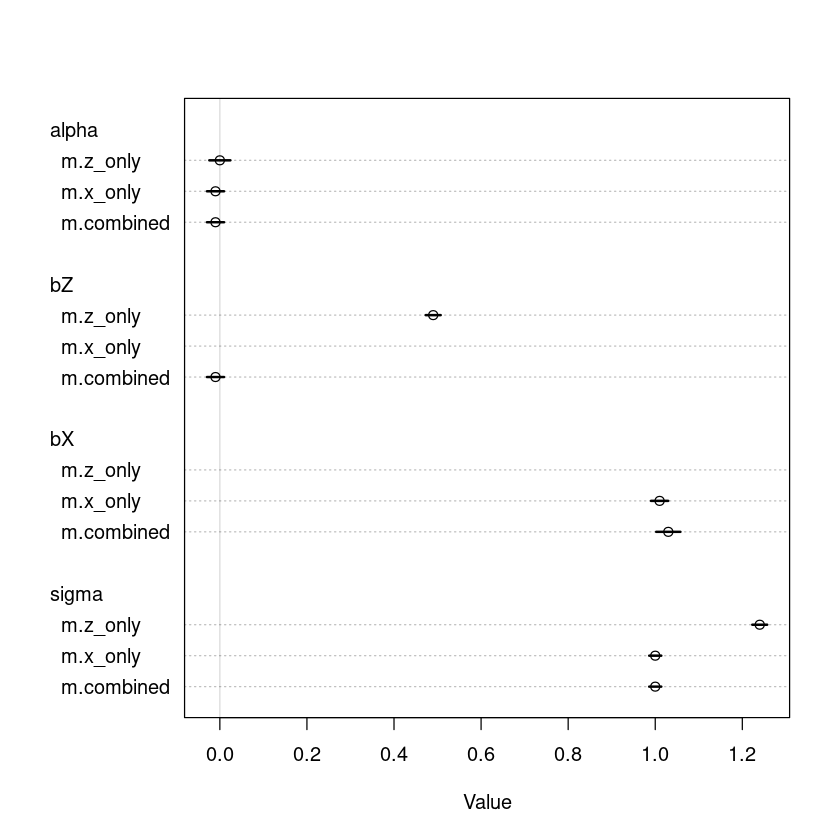

In [69]:
# Say X affects both Y (outcome) and Z (another predictor)
NUM_SAMPLES = 1e4
X <- rnorm(NUM_SAMPLES, 0, 1)
Y <- rnorm(NUM_SAMPLES, X, 1)
Z <- rnorm(NUM_SAMPLES, X, 1)

d <- data.frame(Y=Y, X=X, Z=Z)

m.x_only <- quap(
    alist(
        Y ~ dnorm(mu, sigma),
        mu <- alpha + bX * X,
        alpha ~ dnorm(0, 0.2),
        bX ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.z_only <- quap(
    alist(
        Y ~ dnorm(mu, sigma),
        mu <- alpha + bZ * Z,
        alpha ~ dnorm(0, 0.2),
        bZ ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.combined <- quap(
    alist(
        Y ~ dnorm(mu, sigma),
        mu <- alpha + bX * X + bZ * Z,
        alpha ~ dnorm(0, 0.2),
        bZ ~ dnorm(0, 0.5),
        bX ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

plot(coeftab(m.combined, m.x_only, m.z_only))

Note what happens to the posterior means of $bZ$ - it went basically to zero in the combined one!

**5M2** Invent your own example of a masked relationship. An outcome variable should be correlated with variables, but in the opposite directions And the two predictor variables should be correlated with one another.

**Answer**:

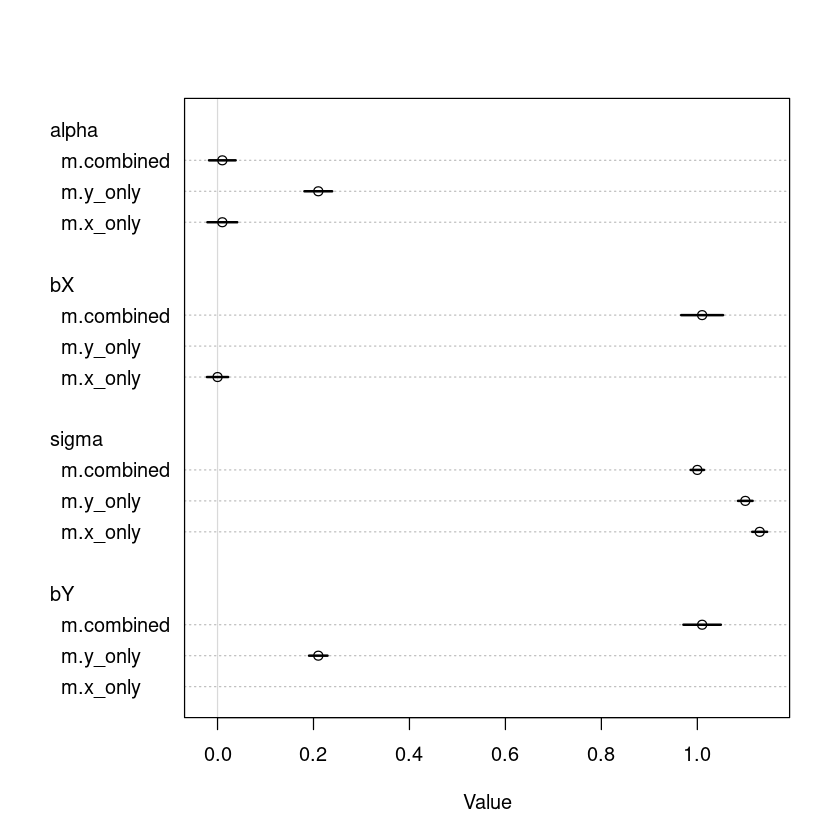

In [70]:
NUM_SAMPLES = 1e4
X <- rnorm(NUM_SAMPLES, 1, 1)
Y <- rnorm(NUM_SAMPLES, -X, 0.5)
Z <- rnorm(NUM_SAMPLES, X + Y, 1)

d <- data.frame(X=X, Y=Y, Z=Z)

m.x_only <- quap(
    alist(
        Z ~ dnorm(mu, sigma),
        mu <- alpha + bX * X,
        alpha ~ dnorm(0, 0.2),
        bX ~ dnorm(1, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.y_only <- quap(
    alist(
        Z ~ dnorm(mu, sigma),
        mu <- alpha + bY * Y,
        alpha ~ dnorm(0, 0.2),
        bY ~ dnorm(-1, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.combined <- quap(
    alist(
        Z ~ dnorm(mu, sigma),
        mu <- alpha + bX * X + bY * Y,
        alpha ~ dnorm(0, 0.2),
        bX ~ dnorm(0, 0.5),
        bY ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
plot(coeftab( m.x_only, m.y_only, m.combined))

**5M3** Sometimes observed that the best predictor of fire risk is the presence of firefighters - states and localities with man firefighters also have more fires. Presumable firefighters do not cause the fires. Nonetheless, this is not a spurious correlation. Instead, fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher mariage rate? Can you think of a way to evaluate this relationship, using multiple regression?

It's possible that a high divorce rate is causing the pool of single (= available to marry) people to be larger. With a larger pool of single people, it's easier to find someone compatible, leading to more marriage. Basically, there's more "churn" in the single / married people, leading to a higher marriage rate.

It might be possible to tease this out if we had information on the number of previous marriages that people had. For instance, if we saw that a good predictor of being married was the number of previous marriages, that might indicate that there's a pool of people dipping in and out ot marriages frequently, and so provide evidence that the high divorce rate was causing the high marriage rate.

**5M4** In the divorce data, states with high numbers of members of the Mormon (LDS) church have much lower divorce rates than the regression models expected. Find a list of LDS population by state and use those numbers as a predictor variable, predicting divorce rate use marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

**Answer**:

Data: [World Population in Review - Mormon Population By State](https://worldpopulationreview.com/state-rankings/mormon-population-by-state). Note that it looks like they got their information from [the church itself](https://newsroom.churchofjesuschrist.org/facts-and-statistics/country/united-states).

In [71]:
lds_df <- read.csv("data/mormonPopulationByState.csv")
head(lds_df)

,fips,state,densityMi,pop2023,pop2022,pop2020,pop2019,pop2010,growthRate,growth,growthSince2010,mormonPop,mormonRate
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,49,Utah,41.66892,3423935,3373162,3271616,3220842,2763885,0.01505,50773,0.23881,2126216,0.62098609
2,6,California,258.20877,40223504,39995077,39538223,39309799,37253956,0.00571,228427,0.07971,756507,0.01880759
3,16,Idaho,23.23926,1920562,1893410,1839106,1811950,1567582,0.01434,27152,0.22517,462069,0.24059051
4,4,Arizona,64.96246,7379346,7303398,7151502,7075549,6392017,0.01040,75948,0.15446,436521,0.05915443
5,48,Texas,116.16298,30345487,29945493,29145505,28745507,25145561,0.01336,399994,0.20679,362037,0.01193051
6,53,Washington,120.37292,7999503,7901429,7705281,7607206,6724540,0.01241,98074,0.18960,289479,0.03618712


In [72]:
d <- WaffleDivorce
head(d)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00


In [73]:
# now merge the two on the `state` (lds_df) -> `Location` (d) field
new_lds <- data.frame(Location=lds_df$state, MormonRate=lds_df$mormonRate)
head(new_lds)

,Location,MormonRate
,<chr>,<dbl>
1,Utah,0.62098609
2,California,0.01880759
3,Idaho,0.24059051
4,Arizona,0.05915443
5,Texas,0.01193051
6,Washington,0.03618712


In [74]:
merged <- merge(x=d, y=new_lds, by="Location")
head(merged)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MormonRate
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,0.007408329
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,0.045242787
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,0.059154429
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,0.010626579
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.018807586
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00,0.025022052


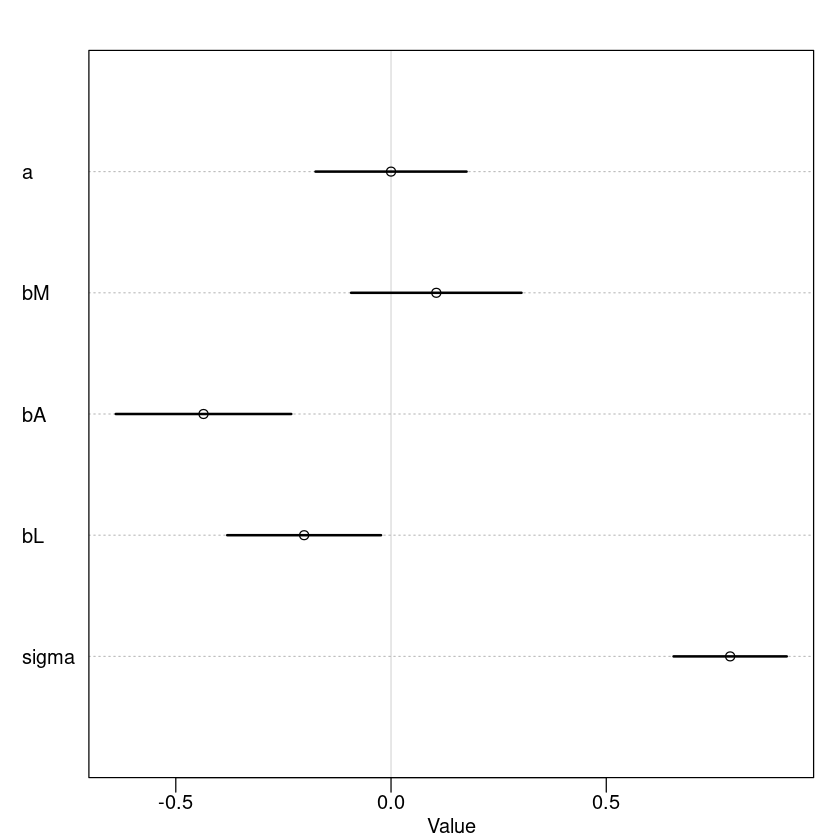

In [75]:
merged$D <- standardize(merged$Divorce)
merged$M <- standardize(merged$Marriage)
merged$A <- standardize(merged$MedianAgeMarriage)
merged$L <- standardize(merged$MormonRate)

m.lds <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A + bL * L,
        a ~ dnorm(0, 0.5),
        bM ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.2),
        bL ~ dnorm(0, 0.2),
        sigma ~ dexp(1)
    ),
    data=merged
)
plot(precis(m.lds))

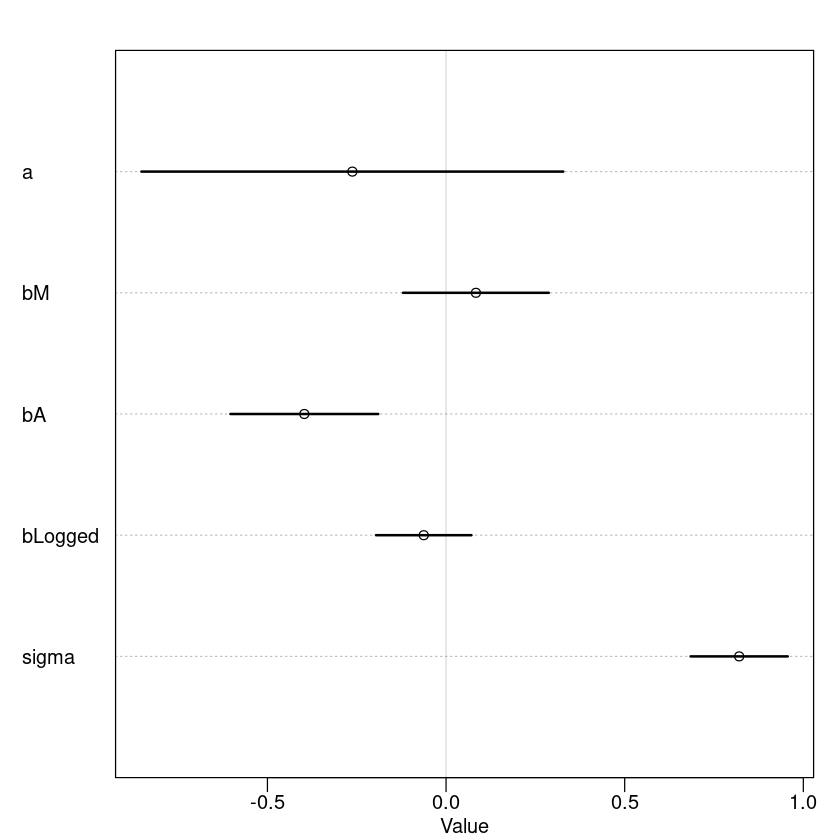

In [76]:
# Since the LDS rate varies so much, what happens if we log it?
merged$LogMormonRate <- log(merged$MormonRate)

m.logged_lds <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A + bLogged * LogMormonRate,
        a ~ dnorm(0, 0.5),
        bM ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.2),
        bLogged ~ dnorm(0, 0.2),
        sigma ~ dexp(1)
    ),
    data=merged
)
plot(precis(m.logged_lds))

**5M5** One way to reson through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (the predictor variable) is positively associated with lower obesity rates (outcome variable). There are at least two important mechanisms by which the price of gasoline could reduce obesity. First, it could lead to less driving -> more exercise. Alternatively, it could lead to less eating out -> fewer calories. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

**Answer**: If you had data about hours of activity / calories burned per day as well as calories ingested, you could test those hypotheses by including those two variables in the regression.

### Hard

**5H1**: In the divorce example, suppose the DAG is $M \to A \to D$. What are the implied independencies of the graph? Are the data consistent with it?

**Answer**: Since the only effect on $D$ comes from $A$, $D \perp M | A$. Let's check with daggitty:

In [77]:
dag <- dagitty("dag{M -> A; A -> D}")
impliedConditionalIndependencies(dag)

D _||_ M | A

So this tells us that if we have a regression with both $M$ and $A$, the coefficient $bM$ should be pretty close to zero. Luckily we have this model already:

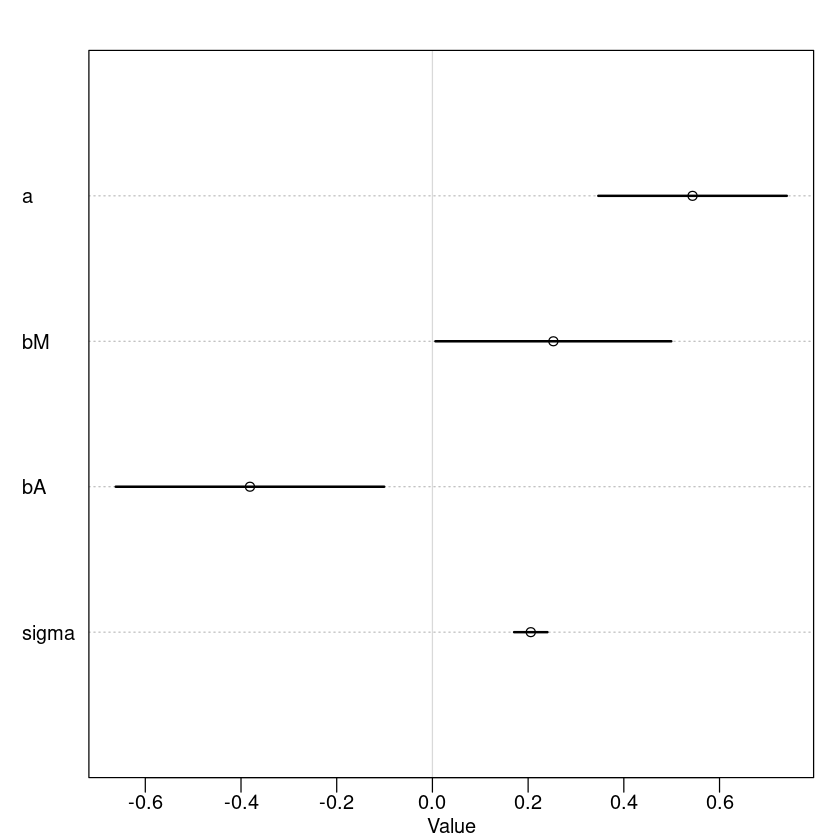

In [78]:
d <- WaffleDivorce
d$D <- normalize(d$Divorce)
d$M <- normalize(d$Marriage)
d$A <- normalize(d$MedianAgeMarriage)

m.5h1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        c(bM, bA) ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
plot(precis(m.5h1))

So... kind of? It's pretty close to zero but not that close.

**5H2**: Assuming that the DAG in the divorce example is indeed $M \to A \to D$, fit a new model and use it to estimate the counterfactual effect of halving a state's marriage rate $M$. Use the counterfactual example from the chapter (p. 140) as a template.

**Answer**:

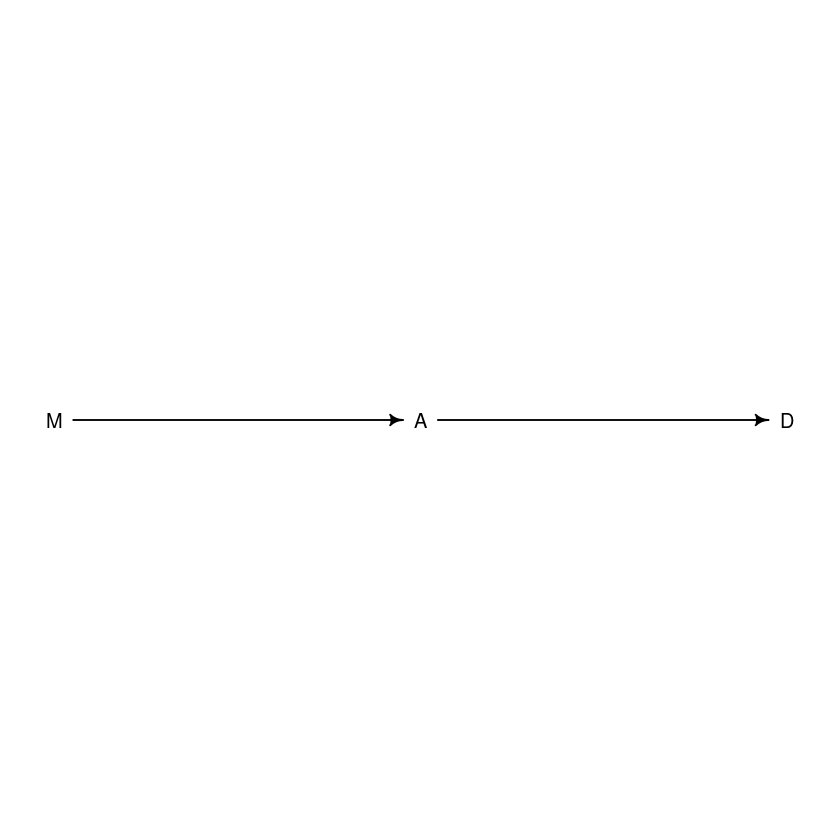

In [80]:
d <- WaffleDivorce
d$D <- normalize(d$Divorce)
d$M <- normalize(d$Marriage)
d$A <- normalize(d$MedianAgeMarriage)# First draw the DAG (easier to visualize):

drawdag(dagitty('
dag{
    M[pos="0,0"]
    A[pos="1,0"]
    D[pos="2,0"]
    M -> A -> D
}
'))

In [81]:
# Now we fit a model: M -> A, A -> D
m.5h2 <- quap(
    alist(
        # A -> D
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1),
        # M -> A
        A ~ dnorm(mu_A, sigma_A),
        mu_A <- aA + bAM * M,
        aA ~ dnorm(0, 0.5),
        bAM ~ dnorm(0, 0.2),
        sigma_A ~ dexp(1)
    ),
    data=d
)
precis(m.5h2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.7102332,0.06793888,0.6016538,0.8188127
bA,-0.5456188,0.14184034,-0.7723070,-0.3189305
sigma,0.1999692,0.02080089,0.1667254,0.2332131
aA,0.6385497,0.03634021,0.5804711,0.6966284
bAM,-0.5210873,0.08088918,-0.6503639,-0.3918108
sigma_A,0.1329993,0.01360619,0.1112539,0.1547446


In [82]:
# Now we simulate what happens for a wide range of $M$ values
m_seq <- seq(from=-2, to=2, length.out=101)

sim_data <- data.frame(M=m_seq)

# Simulate A *and then* D, using sim_data 
# Note the `vars` parameter in sim - that's what's controlling the order
s <- sim(m.5h2, data=sim_data, vars=c("A", "D"))

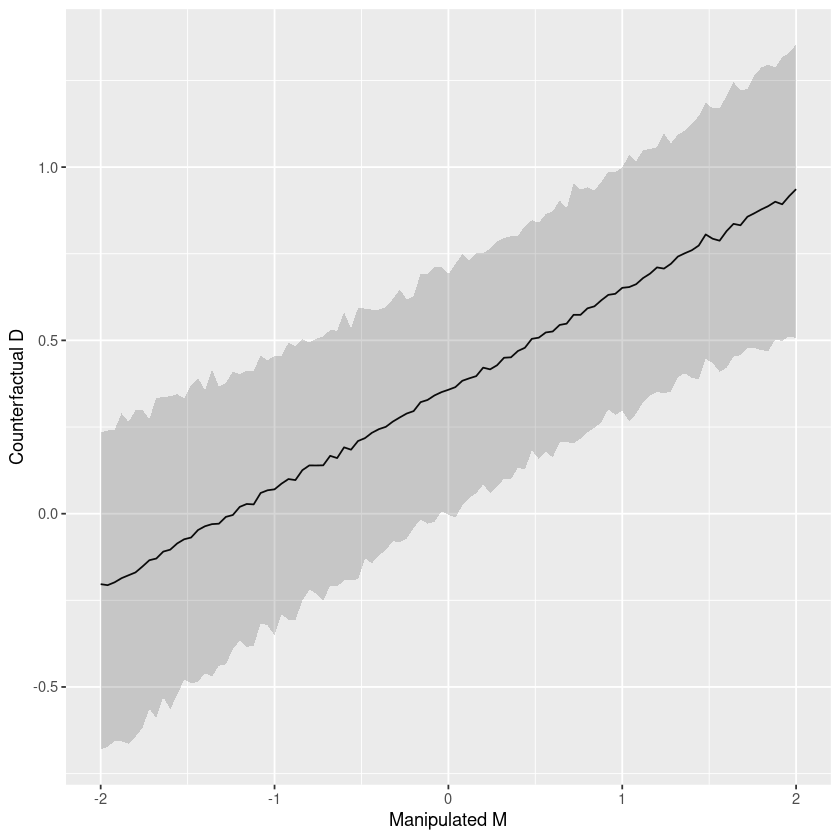

In [83]:
# Plotting the data
D_PI <- apply(s$D, 2, PI)
plot_df <- data.frame(M=sim_data$M, D=colMeans(s$D), lower=D_PI[1,], upper=D_PI[2,])
ggplot(plot_df, aes(M, D)) +
    geom_line() +
    geom_ribbon(mapping=aes(ymin=lower, ymax=upper), alpha=0.2) +
    xlab("Manipulated M") +
    ylab("Counterfactual D")

 By looking at the plot, we can see that decreasing $M$ also decreases $D$. But what we want to know is the effect of *halving* $M$. So, let's run a new simulation where we take all of the old marriage rates, halve them, and see how the new simulated $D$ values compare:

In [113]:
old_mean <- mean(d$Marriage)
old_sd <- sd(d$Marriage)
manipulated_m <- (d$Marriage/ 2 - old_mean) / old_sd

original_sim_data <- data.frame(M=d$M)
original_sim <- sim(m.5h2, data=original_sim_data, vars=c("A", "D"))
str(original_sim)

List of 2
 $ A: num [1:1000, 1:50] 0.342 0.2939 0.0968 0.4874 0.3591 ...
 $ D: num [1:1000, 1:50] 0.734 0.629 1.354 0.615 0.435 ...


In [114]:
original_mean <- mean(original_sim$D)
original_mean

[1] 0.473581

In [115]:
old_mean <- mean(d$Marriage)
old_sd <- sd(d$Marriage)
manipulated_m <- (d$Marriage / 2 - old_mean) / old_sd

manipulated_sim_data <- data.frame(M=manipulated_m)
manipulated_sim <- sim(m.5h2, data=manipulated_sim_data, vars=c("A", "D"))
manipulated_mean <- mean(manipulated_sim$D)
manipulated_mean

[1] -0.3911509

In [116]:
# effect:
manipulated_mean - original_mean

[1] -0.8647319

So from this, we can see that the effect of halving the marriage rate results in a drop of about 0.8 standard deviations - a pretty good effect!

**5H3**: Milk energy model `m5.7`. Suppose that the true causal relationship is

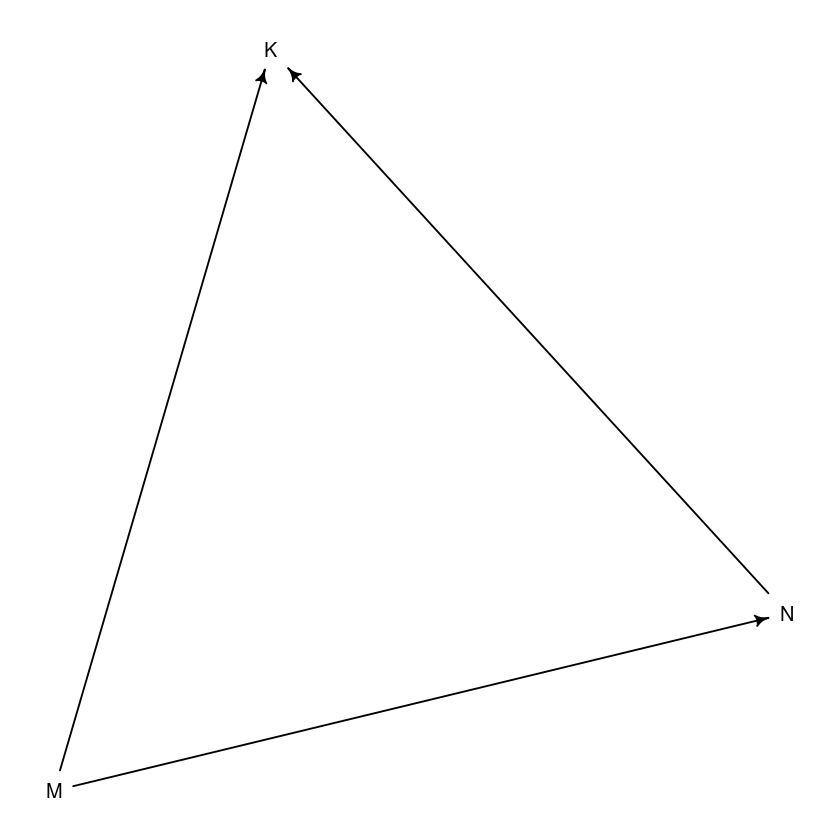

In [109]:
dag <- dagitty("dag{M -> N; M -> K; N -> K}")
drawdag(dag)

Now compute the counterfactual effect on $K$ of doubling $M$. You will need to account for both direct and indirect paths of causation. Use the counterfactual exmple from the chapter (p. 140) as a template).

**Answer**:

In [118]:
# Model - we need to simulate the direct and indirect effects on K
data(milk)
d <- milk
d$K <- standardize(d$kcal.per.g)
d$N <- standardize(d$neocortex.perc)
d$M <- standardize(log(d$mass))

d <- d[complete.cases(d$K, d$N, d$M),]

In [119]:
m.5h3 <- quap(
    alist(
        # M -> K; N -> K
        K ~ dnorm(mu, sigma),
        mu <- a + bM * M + bN * N,
        a ~ dnorm(0, 0.2),
        c(bM, bN) ~ dnorm(0, 0.5),
        sigma ~ dexp(1),
        # M -> N
        N ~ dnorm(mu_N, sigma_N),
        mu_N <- a_N + bNM * M,
        a_N ~ dnorm(0, 0.2),
        bNM ~ dnorm(0, 0.5),
        sigma_N ~ dexp(1)
    ),
    data=d
)

In [128]:
logged_mass <- log(d$mass)
manipulated_M <- (2 * logged_mass - mean(logged_mass)) / sd(logged_mass)

# original
sim_data <- data.frame(M=d$M)
original_sim <- sim(m.5h3, data=sim_data, vars=c("N", "K"))
original_mean <- mean(original_sim$K)
original_mean

# doubled
manipulated_sim_data <- data.frame(M=d$M)
manipulated_sim <- sim(m.5h3, data=manipulated_sim_data, vars=c("N", "K"))
maniplated_mean <- mean(manipulated_sim$K)
manipulated_mean

Warning message in if (left == var) {:
“the condition has length > 1 and only the first element will be used”


[1] 0.05813997

Warning message in if (left == var) {:
“the condition has length > 1 and only the first element will be used”


[1] -0.3911509

In [129]:
# difference
manipulated_mean - original_mean

[1] -0.4492908

From this we can estimate that doubling the mass would lower the caloric density of the milk by about half a standard deviation.